In [1]:
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from utils.io import load_json, load
from utils.Logger import Logger
from utils.experiment_evaluator import Evaluator
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

data_directory = '../experiments_results/'
experiments = [dI for dI in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, dI))]
# experiments = [dI for dI in experiments if not dI[0] == '_']
experiments.sort(key=lambda x: x.lower())

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
def get_styles(exp):
    exp = exp.lower()
    if 'ar_lstm' in exp:
        style = '-'
    elif 'convls' in exp:
        style = ':'
    elif 'resnet' in exp:
        style =  '--'
    else:
        style = '-.'
    return style

# Dataframe creation from pickles

In [4]:
test_set = 'Test'

In [5]:
# experiment = 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7'
# ev = load('../experiments_results/' + experiment + '/pickles/evaluator_%s_sp_15.pickle' % test_set)
# ev.get_rmse_values_previous_frame().head()

In [6]:
# experiment = 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_16h'
# ev = load('../experiments_results/' + experiment + '/pickles/evaluator_%s_sp_15.pickle' % test_set)
# df = ev.get_rmse_values_previous_frame()
# plt.plot(df['mean'])
# experiment = 'ar_lstm_batch_16_samples_5_in_5_out_20_normal_lr_0.0001'
# ev = load('../experiments_results/' + experiment + '/pickles/evaluator_%s_sp_15.pickle' % test_set)
# plt.plot(df['mean'])
# experiment = 'resnet_batch_16_samples_5_in_5_out_10_normal_lr_0.001'
# ev = load('../experiments_results/' + experiment + '/pickles/evaluator_%s_sp_15.pickle' % test_set)
# df = ev.get_rmse_values_previous_frame()
# plt.plot(df['mean'])


# df = ev.get_rmse_values_previous_frame()
# plt.plot(df['mean'])
# df = ev.get_rmse_values()
# # plt.plot(df['mean'])

In [7]:
testset_exp_eval = {}
testset_exp_eval_full = {}
test_sets = ["Test", "Lines", "Double_Drop", "Illumination_135", "Illumination_Random", 
            "Shallow_Depth", "Smaller_Tub", "Bigger_Tub", 'Fixed_Tub_10']
for test_set in test_sets:
    print(test_set)
    testset_exp_eval[test_set] = {}
    testset_exp_eval_full[test_set] = {}
    for experiment in experiments:
        try:
            ev = load('../experiments_results/' + experiment + '/pickles/evaluator_%s_sp_15.pickle' % test_set)
            df = ev.get_rmse_values()
            x = df.index.values
            y_error = df['mean'].values
            df = ev.get_ssim_values()
            y_ssim = df['mean'].values
            md = load_json('../experiments_results/' + experiment + '/pickles/metadata.pickle.json')
            md['args']['belated'] = False
            testset_exp_eval[test_set][experiment] = {'frame': x, 'error': y_error, 'ssim':y_ssim, 'args': md['args']}
            testset_exp_eval_full[test_set][experiment] = ev

            if ('predrnn' in experiment) or 'lstm' in experiment:
                ev = load('../experiments_results/' + experiment + '/pickles/belated_evaluator_%s_sp_15.pickle' %test_set)
                df = ev.get_rmse_values()
                x = df.index.values
                y_error = df['mean'].values
                df = ev.get_ssim_values()
                y_ssim = df['mean'].values
                md = load_json('../experiments_results/' + experiment + '/pickles/metadata.pickle.json')
                md['args']['belated'] = False
                testset_exp_eval[test_set][experiment+'_belated'] = {'frame': x, 'error': y_error, 'ssim':y_ssim, 'args': md['args']}
                testset_exp_eval_full[test_set][experiment+'_belated'] = ev
        except:
            pass
#             print(experiment)

Test
Lines
Double_Drop
Illumination_135
Illumination_Random
Shallow_Depth
Smaller_Tub
Bigger_Tub
Fixed_Tub_10


# Comparing results

In [8]:
test_set = 'Test'
evaluators = testset_exp_eval[test_set]

In [9]:
# df = pd.DataFrame.from_dict({'frame': ev['frame'], 'error': ev['error'], 'ssim': ev['ssim']})
# bins = pd.cut(df['frame'], [-1, 9, 19, 29, 39, 49, 59, 69, 79], )
# dfb = df.groupby(bins)['error'].agg(['mean']).round(3).reset_index(drop=True)
# dfb.rename(columns={"mean": exp}, inplace=True)
# # dfb

In [10]:
# bins = 10*[0] + 10*[1] + 10*[2] + 10*[3] + 10*[4] + 10*[5] + 10*[6] + 10*[7]
# df['bins'] = bins
# dfb = df.groupby(bins)[['error','ssim']].agg('mean').round(3).reset_index(drop=True)
# dfb['exp'] = exp
# dfb = dfb.reset_index()
# dfb = dfb.pivot(index='exp', columns='index')

In [11]:
dff = None
for exp, ev in evaluators.items():
#     print(exp)
    df = pd.DataFrame.from_dict({'frame': ev['frame'], 'error': ev['error']})
    bins = pd.cut(df['frame'], [-1, 9, 19, 29, 39, 49, 59, 69, 79], )
    dfb = df.groupby(bins)['error'].agg(['mean']).round(3).reset_index(drop=True)
    dfb.rename(columns={"mean": exp}, inplace=True)
    if dff is None:
        dff = dfb
    else:
        dff = dff.join(dfb)
dff = dff.T

dff['short'] = ((dff[0] + dff[1] + dff[2])/3).round(3)
dff['short-med'] = ((dff[0] + dff[1] + dff[2] + dff[3] + dff[4])/5).round(3)
dff['med'] = ((dff[3] + dff[4] + dff[5])/3).round(3)
dff['long'] = ((dff[5] + dff[6] + dff[7])/3).round(3)
dff['mean'] = dff.mean(axis=1).round(3)


for exp in dff.index:
    args = evaluators[exp]['args']
    if 'dataset' in args:
        dff.loc[exp, 'dataset'] = args['dataset']
    else:
        dff.loc[exp, 'dataset'] = 'original'
    dff.loc[exp, 'model'] = args['model_type']
    dff.loc[exp, 'batch'] = args['batch_size']
    dff.loc[exp, 'samples'] = args['samples_per_sequence']
    dff.loc[exp, 'in'] = args['num_input_frames']
    dff.loc[exp, 'out'] = args['num_output_frames']
    dff.loc[exp, 'LR'] = args['learning_rate']
    dff.loc[exp, 'patience'] = args['scheduler_patience']
    dff.loc[exp, 'belated'] = args['belated']
    
    if '16h' in args['experiment_name']:
        time = 16
    elif '16h' in args['experiment_name']:
        time = 24
    else:
        time = 8
        
    dff.loc[exp, 'time'] = time
    
    other = args['experiment_name'].split('_')[-1]
    if not(other == 2 or other == 'c'):
        other = 'na'
    dff.loc[exp, 'other'] = other

# Find best per model 

In [12]:
dff_fixed_tub = dff[dff['dataset'] == 'fixed_tub']
dff_original = dff[dff['dataset'] == 'original']
dff_original.columns

# exp_to_plot = dff_fixed_tub.groupby(["model"])["short"].idxmin().values
# exp_to_plot = dff_fixed_tub.index.values

Index([          0,           1,           2,           3,           4,
                 5,           6,           7,     'short', 'short-med',
             'med',      'long',      'mean',   'dataset',     'model',
           'batch',   'samples',        'in',       'out',        'LR',
        'patience',   'belated',      'time',     'other'],
      dtype='object')

In [13]:
best_exps_per_segment = {}
exp_to_plot = []
columns = dff_original.columns[:13]
for i in columns:
    best_exps_per_segment[i] = list(dff_original.groupby("model")[i].idxmin().values)
    exp_to_plot += list(dff_original.groupby("model")[i].idxmin().values)
exp_to_plot = list(set(exp_to_plot))
exp_to_plot.sort()

In [14]:
best_exps_per_model_segment = {}
columns = dff_original.columns[:13]

for m in dff.model.unique():
    best_exps_per_model_segment[m] = {}
    dff_model = dff_original[dff_original.model==m]
    for c in columns:
        best_exps_per_model_segment[m][c] = list(dff_model.groupby("model")[c].idxmin().values)[0]

In [15]:
best_exps_per_model = {}

for k,v in best_exps_per_model_segment.items():
    best_exps_per_model[k] = list(set(v.values()))
    
# best_exps_per_model

In [16]:
# best_exps_per_model_segment

# Plot the best exp of each model for a specific segment

In [17]:
best_exps_per_segment['mean']

['ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5',
 'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated',
 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated',
 'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7',
 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7']

In [18]:
best_exps_per_segment['short-med']

['ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5',
 'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated',
 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated',
 'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7',
 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7']

In [19]:
# Best models
#  ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5
#  convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated
#  predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated
#  resnet_batch_16_samples_5_in_5_out_10_normal_lr_0.001_16h_c
#  resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7
#  unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7

In [20]:
segment = 'short-med'
test_set = 'Test'


traces = []
evaluators = testset_exp_eval[test_set]
for i, exp in enumerate(best_exps_per_segment[segment]):
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name= exp, 
                             marker_color = plotly.colors.DEFAULT_PLOTLY_COLORS[i%10],
                             opacity=1))

layout = dict(legend=dict(y=0.9, font=dict( size=6)), title='%s set performance' %test_set,
             xaxis=dict(title='Time step'),
             yaxis=dict(title='RMSE'))

ff = plotly.offline.iplot({"data": traces, "layout": layout })

# Plot all exps for model

In [21]:
dff.model.unique()

array(['ar_lstm', 'convlstm', 'predrnn', 'resnet_dilated', 'unet'],
      dtype=object)

In [22]:
model_to_plot = 'convlstm'
test_sets_plot = [test_sets[0]]

traces = []
for k, test_set in enumerate(test_sets_plot):
    evaluators = testset_exp_eval[test_set]
    for i, exp in enumerate(list(dff[dff.model==model_to_plot].index.values)):
        ev = evaluators[exp]
        x = ev['frame']
        y = ev['error']
        traces.append(go.Scatter(x=x, y=y, name=exp, 
                                 marker_color = plotly.colors.DEFAULT_PLOTLY_COLORS[i % 10],
                                 opacity=1/(k+1)))

layout = dict(legend=dict(y=0.9, font=dict( size=6)), title='%s set performance' %test_set,
             xaxis=dict(title='Time step'),
             yaxis=dict(title='RMSE'))

ff = plotly.offline.iplot({"data": traces, "layout": layout })

# Plot all the best experiments for each model

In [23]:
model_to_plot = 'predrnn'
test_set = 'Test'

traces = []
evaluators = testset_exp_eval[test_set]
for i, exp in enumerate(best_exps_per_model[model_to_plot]):
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=exp, 
                             marker_color = plotly.colors.DEFAULT_PLOTLY_COLORS[i],
                             opacity=1/(k+1)))
    
layout = dict(legend=dict(y=0.9, font=dict( size=6)), title='%s set performance' %test_set,
             xaxis=dict(title='Time step'),
             yaxis=dict(title='RMSE'))


ff = plotly.offline.iplot({"data": traces, "layout": layout })

# Plot generalization of best exps for model

In [24]:
model_to_plot = 'predrnn'
test_sets_plot = [test_sets[5]]

traces = []
for k, test_set in enumerate(test_sets_plot):
    evaluators = testset_exp_eval[test_set]
    for i, exp in enumerate(best_exps_per_model[model_to_plot]):
        ev = evaluators[exp]
        x = ev['frame']
        y = ev['error']
        traces.append(go.Scatter(x=x, y=y, name=exp, 
                                 marker_color = plotly.colors.DEFAULT_PLOTLY_COLORS[i],
                                 opacity=1/(k+1)))

layout = dict(legend=dict(y=0.9, font=dict( size=6)), title='%s set performance' %test_set,
             xaxis=dict(title='Time step'),
             yaxis=dict(title='RMSE'))

ff = plotly.offline.iplot({"data": traces, "layout": layout })

# Plot all generalization for one experiment

In [25]:
model = 'predrnn'
exp = best_exps_per_model[model][0]
# best_exps_per_segment['mean'][2]

traces = []
for ts in test_sets:
    evaluators = testset_exp_eval[ts]
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=ts))

layout = dict(legend=dict(y=0.9, font=dict( size=20)), title=exp,
                xaxis=dict(title='Time step'),
             yaxis=dict(title='RMSE'))

ff = plotly.offline.iplot({"data": traces, "layout": layout })

In [26]:
exp = best_exps_per_model[model][0]

traces = []
for ts in test_sets:
    evaluators = testset_exp_eval[ts]
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=ts))

layout = dict(legend=dict(y=0.9, font=dict( size=20)), title=exp)

ff = plotly.offline.iplot({"data": traces, "layout": layout })

In [27]:
exp = best_exps_per_model[model][1]

traces = []
for ts in test_sets:
    evaluators = testset_exp_eval[ts]
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=ts))

layout = dict(legend=dict(y=0.9, font=dict( size=20)), title=exp)

ff = plotly.offline.iplot({"data": traces, "layout": layout })

# Plot generalization of specific model

In [28]:
dff[dff.model=='predrnn']

0      1      2  \
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.013  0.017  0.020   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.013  0.017  0.021   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.012  0.016  0.023   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.012  0.016  0.022   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.012  0.016  0.026   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.012  0.016  0.024   
predrnn_batch_4_samples_5_in_5_out_40_normal_lr...  0.019  0.021  0.026   
predrnn_batch_4_samples_5_in_5_out_40_normal_lr...  0.019  0.021  0.026   

                                                        3      4      5  \
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.024  0.028  0.031   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.024  0.027  0.029   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.054  0.114  0.175   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.030  0.041  0.054   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.058  0.112  0.171   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.034  0.048  0.064   
predrnn_batch_4_samples_5_in_5_out_40_normal_lr...  0.033  0.041  0.055   
predrnn_batch_4_samples_5_in_5_out_40_normal_lr...  0.033  0.046  0.054   

                                                        6      7  short  \
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.033  0.037  0.017   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.032  0.034  0.017   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.209  0.220  0.017   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.069  0.085  0.017   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.209  0.216  0.018   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.084  0.105  0.017   
predrnn_batch_4_samples_5_in_5_out_40_normal_lr...  0.083  0.123  0.022   
predrnn_batch_4_samples_5_in_5_out_40_normal_lr...  0.065  0.076  0.022   

                                                    short-med  ...    model  \
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...      0.020  ...  predrnn   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...      0.020  ...  predrnn   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...      0.044  ...  predrnn   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...      0.024  ...  predrnn   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...      0.045  ...  predrnn   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...      0.027  ...  predrnn   
predrnn_batch_4_samples_5_in_5_out_40_normal_lr...      0.028  ...  predrnn   
predrnn_batch_4_samples_5_in_5_out_40_normal_lr...      0.029  ...  predrnn   

                                                    batch  samples   in   out  \
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...    4.0      5.0  5.0  20.0   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...    4.0      5.0  5.0  20.0   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...    4.0      5.0  5.0  20.0   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...    4.0      5.0  5.0  20.0   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...    4.0      5.0  5.0  20.0   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...    4.0      5.0  5.0  20.0   
predrnn_batch_4_samples_5_in_5_out_40_normal_lr...    4.0      5.0  5.0  40.0   
predrnn_batch_4_samples_5_in_5_out_40_normal_lr...    4.0      5.0  5.0  40.0   

                                                        LR  patience  belated  \
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.0001       3.0    False   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.0001       3.0    False   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.0001       3.0    False   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.0001       3.0    False   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.0001       3.0    False   
predrnn_batch_4_samples_5_in_5_out_20_normal_lr...  0.0001       3.0    False   
predrnn_batch_4_sam

In [29]:
# exp = 'unet_batch_16_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_7'
exp = 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated'
# exp = 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7'
# exp = 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True_belated'

traces = []
for ts in test_sets:
    evaluators = testset_exp_eval[ts]
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=ts))

layout = dict(legend=dict(y=0.9, font=dict( size=20)), title=exp)

ff = plotly.offline.iplot({"data": traces, "layout": layout })

# q-grid

In [30]:
import qgrid
qgrid.show_grid(dff[dff.columns[~dff.columns.isin([2,3,4,5,6,7])]], 
                grid_options={'forceFitColumns': False, 
                              'defaultColumnWidth': 70})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

# All models

In [31]:
test_set = 'Test'
evaluators = testset_exp_eval[test_set]

traces = []
for exp, ev in evaluators.items():
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=exp,
                            visible = 'legendonly'))
layout = dict(
    legend=dict(
        y=0.9,
        font=dict(
            size=6)))

ff = plotly.offline.iplot({
        "data": traces,
        "layout": layout
    })

# Keep only the best exp of each model

In [32]:
all_exp_2 = len(dff[(dff.dataset=='original') & (dff.belated==False)])

In [33]:
all_exp = dff[dff.dataset=='original'].index.values

In [34]:
keep_exp = dff[dff.dataset=='original'].groupby('model')['mean'].nsmallest(5).index.values
keep_exp = [b for a,b in keep_exp]

In [35]:
dff[dff.dataset=='fixed_tub'].index.values

array(['ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_5',
       'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_dataset_fixed_tub_24h_patience_5',
       'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_dataset_fixed_tub_24h_patience_5_belated',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_3',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_3_belated',
       'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_fixed_tub_24h_patience_7',
       'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_7'],
      dtype=object)

# Seaborn plot

In [36]:
dff[dff.dataset=='original'].index.values

array(['ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5',
       'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5_belated',
       'convlstm_batch_6_samples_5_in_5_out_20_normal_lr_0.001',
       'convlstm_batch_6_samples_5_in_5_out_20_normal_lr_0.001_belated',
       'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c',
       'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True_belated',
       'predrnn_batch_4_samples_5_in_5_out_40_normal_lr_0.0001

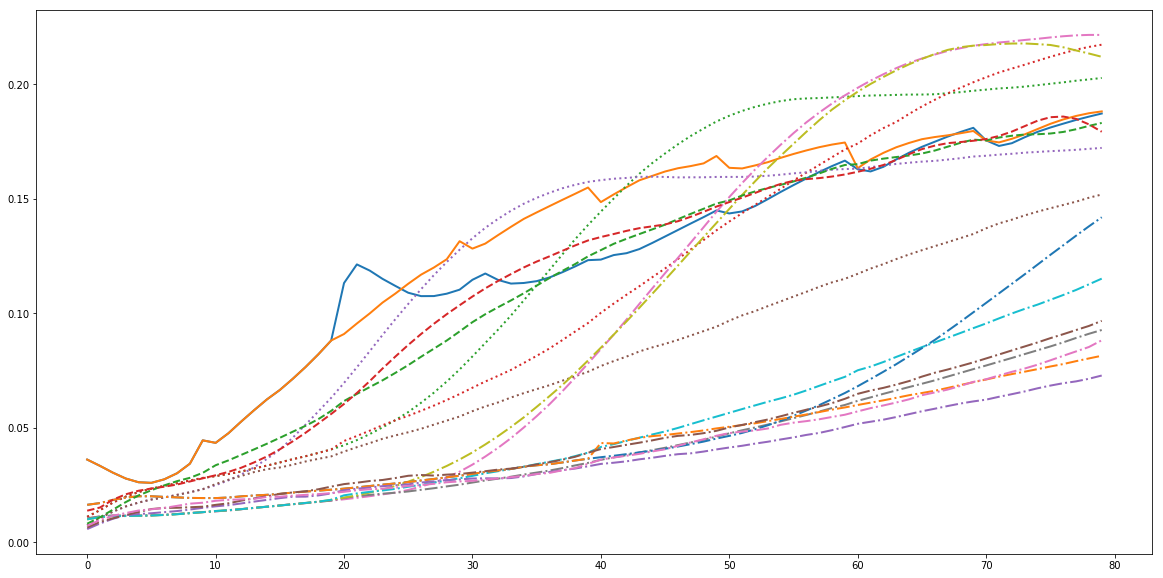

In [37]:
exps_to_show = list(dff[dff.dataset=='original'].index.values)

fig = plt.figure(figsize=(20,10)).add_axes()
for exp in exps_to_show:
    ev = evaluators[exp]
    y = ev['error']
    x = ev['frame']
    style = get_styles(exp)
    plt.plot(x, y, label=' '+exp, linewidth=2, linestyle=style)
# plt.legend()
plt.show()

# AR_LSTM Baselines

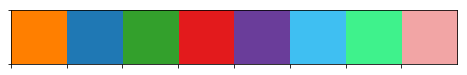

In [38]:
paired = sns.color_palette("Paired", 20)
paired.insert(0, paired[6])
paired.insert(1, paired[8])

paired.insert(8, paired[10])
paired.insert(9, paired[12])

paired.insert(10, paired[14])
paired.insert(11, paired[16])

palette = paired[1:10:2]

palette.append((0.25, 0.75, 0.95))
palette.append((0.25, 0.95, 0.55))
palette.append((0.95, 0.65, 0.65))


sns.palplot(palette)

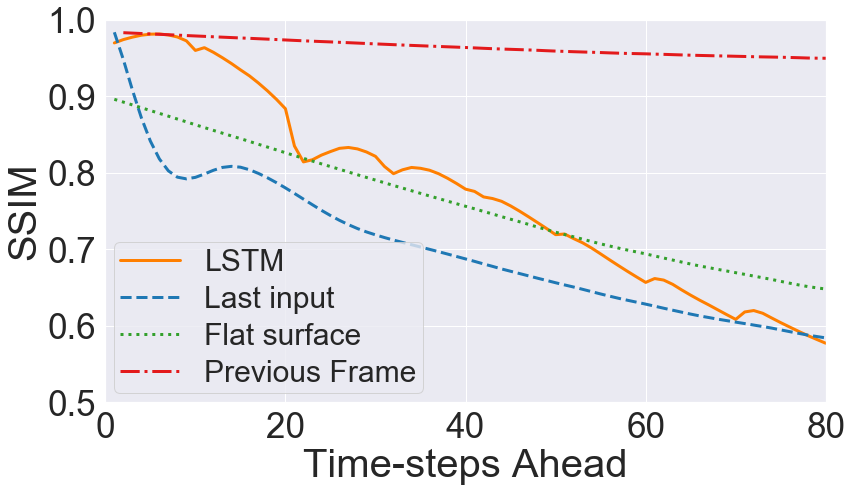

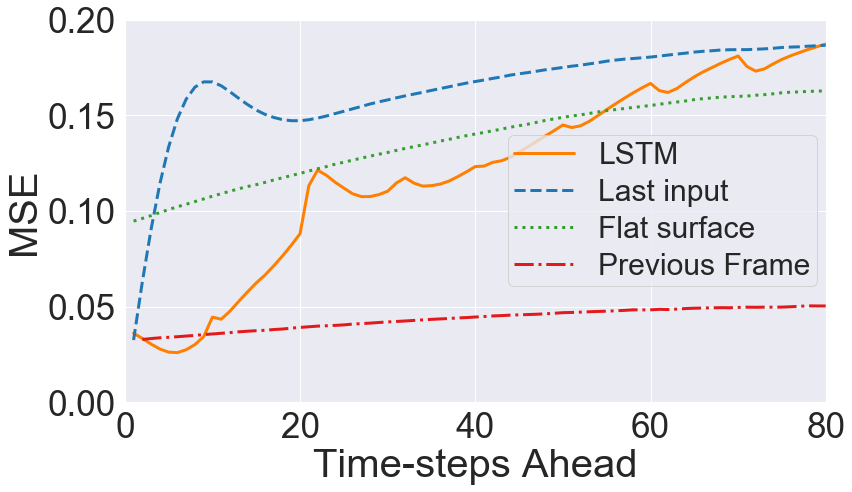

In [39]:
test_set = 'Test'
baselines=['', 'last_input_', 'flat_image_', 'previous_frame_']
evaluators_full = testset_exp_eval_full[test_set]

ff=5
for metric in['SSIM', 'MSE']:
    exp = 'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5'
    ci = None

    ff = 10
#     sns.set(style="whitegrid")
    sns.set(rc={'figure.figsize':(12,7), 
            "lines.linewidth": 3,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+5, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})
    # sns.set_context("paper", font_scale=1)

    # fig = plt.figure(figsize=(a12,18)).add_axes()
    dfs = []
    ev = evaluators_full[exp]

    legend={'':'LSTM', 'last_input_': 'Last input', 'flat_image_': 'Flat surface', 
           'previous_frame_': 'Previous Frame'}

    x_title = 'Time-steps Ahead'
    y_title = metric

    for baseline in baselines:
        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = legend[baseline]

        dfs.append(df)
        dfss = pd.concat(dfs)

    ll = len(baselines)
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, 
                      ax=fig, ci=None, palette=palette[:ll]) # palette=palette[:ll])
    style0 = ''
    style1 = "--"
    style2 = ":"
    style3 = "-."

    ax.lines[1].set_linestyle(style1)
    ax.lines[2].set_linestyle(style2)
    ax.lines[3].set_linestyle(style3)

    # {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}

    if metric == 'MSE':
        ax.set_ylim([0, 0.2])
        plt.yticks([0, 0.05, 0.1, 0.15, .20])

    else:
        ax.set_ylim([0.5, 1])

    ax.set_xlim([0, 80])


    handles, labels = ax.get_legend_handles_labels()

    handles[2].set_linestyle(style1)
    handles[3].set_linestyle(style2)
    handles[4].set_linestyle(style3)



    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)
    plt.tight_layout()
    plt.savefig('results/%s/arlstm_%s_%s.pdf' % (metric, metric,ci))
    plt.figure()
    # plt.savefig('results/arlstm_%s.png' % metric)
plt.close()

# LSTM vs FCN

ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5
resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7
ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5
resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7


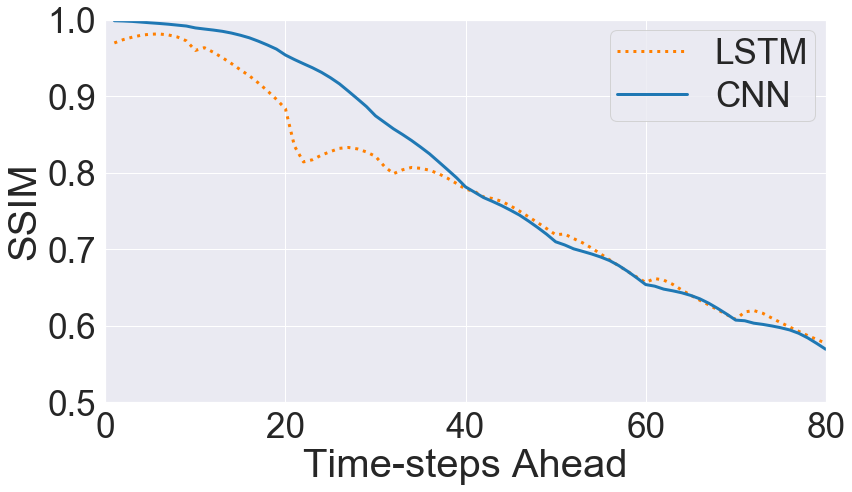

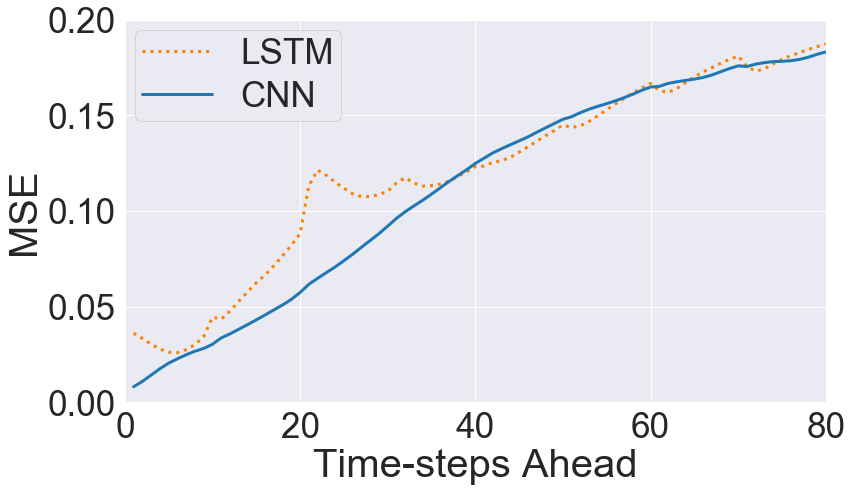

<Figure size 864x504 with 0 Axes>

In [40]:
test_set = 'Test'
baseline=''
evaluators_full = testset_exp_eval_full[test_set]
exps = {
    'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
        'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7':'CNN'}
ci = None

ff = 10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,7), 
            "lines.linewidth": 3,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})
for metric in['SSIM', 'MSE']:

    # fig = plt.figure(figsize=(12,18)).add_axes()
    dfs = []
    dfss = None

    for exp, name in exps.items():
        print(exp)
        ev = evaluators_full[exp]



        x_title = 'Time-steps Ahead'
        y_title = metric

        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = name

        dfs.append(df)
        dfss = pd.concat(dfs)

    ll = len(exps)
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=None, palette=palette[:ll])

    ax.lines[0].set_linestyle(":")


    if metric == 'MSE':
        ax.set_ylim([0, 0.2])
        plt.yticks([0, 0.05, 0.1, 0.15, .20])
    else:
        ax.set_ylim([0.5, 1])

    ax.set_xlim([0, 80])

    handles, labels = ax.get_legend_handles_labels()
    handles[1].set_linestyle(":")
    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

    plt.tight_layout()
    plt.savefig('results/%s/cnn_%s_%s.pdf' % (metric, metric,ci))
    plt.figure()
    # plt.savefig('results/arlstm_%s.png' % metric)

# Choose a model 

convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c
convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated
convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c
convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated


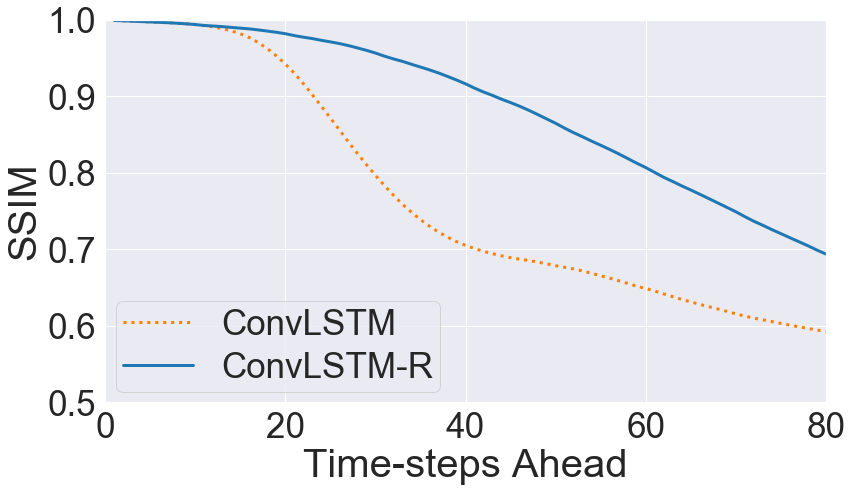

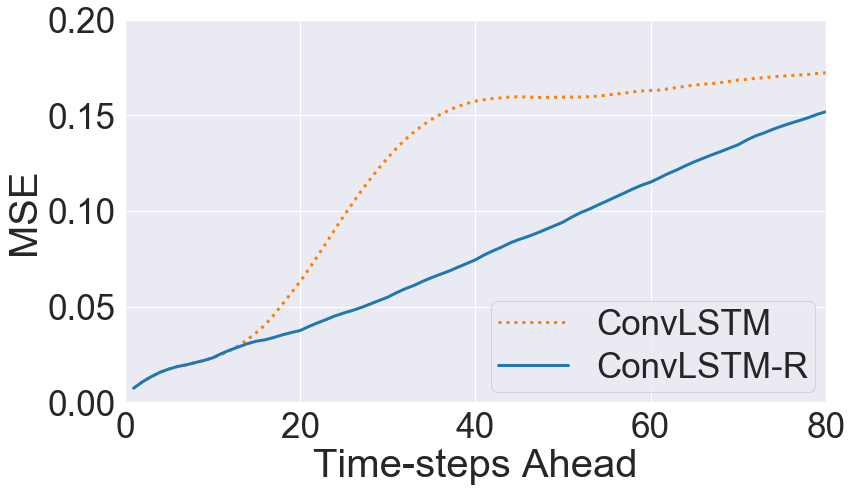

<Figure size 864x504 with 0 Axes>

In [41]:
test_set = 'Test'
baseline=''
evaluators_full = testset_exp_eval_full[test_set]
exps = {
#     'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
            'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c': 'ConvLSTM',
        'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM-R',
#         'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3': 'Causal LSTM',
#         'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM-R'
#
#     'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7':'CNN'
#                'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7':'CDNN'
}
ci = None

ff = 10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,7), 
            "lines.linewidth": 3,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})
for metric in['SSIM', 'MSE']:

    # fig = plt.figure(figsize=(12,18)).add_axes()
    dfs = []
    dfss = None

    for exp, name in exps.items():
        print(exp)
        ev = evaluators_full[exp]



        x_title = 'Time-steps Ahead'
        y_title = metric

        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = name

        dfs.append(df)
        dfss = pd.concat(dfs)

    ll = len(exps)
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=None, palette=palette[:ll])

    ax.lines[0].set_linestyle(":")


    if metric == 'MSE':
        ax.set_ylim([0, 0.2])
        plt.yticks([0, 0.05, 0.1, 0.15, .20])
    else:
        ax.set_ylim([0.5, 1])

    ax.set_xlim([0, 80])

    handles, labels = ax.get_legend_handles_labels()
    handles[1].set_linestyle(":")
    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

    plt.tight_layout()
    plt.savefig('results/%s/%s_%s_%s.pdf' % (metric, name, metric,ci))
    plt.figure()
    # plt.savefig('results/arlstm_%s.png' % metric)

# ConvLSTM

ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5
convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c


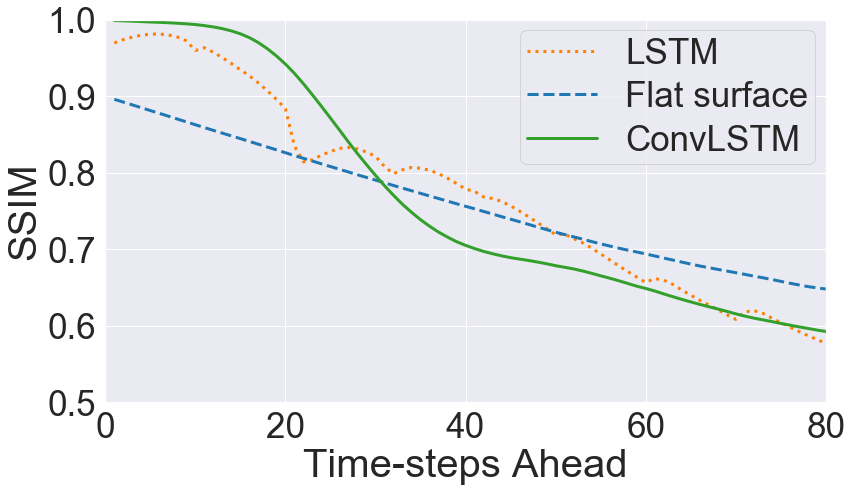

<Figure size 864x504 with 0 Axes>

In [42]:
test_set = 'Test'
baseline=''
evaluators_full = testset_exp_eval_full[test_set]
exps = {
    'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
        'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c': 'ConvLSTM',
    
}
ci = None

ff=10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,7), 
            "lines.linewidth": 3,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

# fig = plt.figure(figsize=(12,18)).add_axes()

for metric in['SSIM']:

    dfs = []
    dfss = None
    df = None

    for exp, name in exps.items():
        print(exp)
        ev = evaluators_full[exp]
        x_title = 'Time-steps Ahead'
        y_title = metric
        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = name
        dfs.append(df)
        dfss = pd.concat(dfs)

        if name=='LSTM':
            baseline='flat_image_'
            ev = evaluators_full[exp]
            x_title = 'Time-steps Ahead'
            y_title = metric
            all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
                y_title:              ev.state['%s_%sval' % (metric, baseline)],
                "type":               ev.state['%s_%shue' % (metric,baseline)]}
            df = pd.DataFrame.from_dict(all_data)
            df['Line'] = legend[baseline]
            dfs.append(df)
            dfss = pd.concat(dfs)  
            baseline=''


  


    ll = len(exps)
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=None, palette=palette[:ll+1])

    ax.lines[0].set_linestyle(":")
    ax.lines[1].set_linestyle("--")


    if metric == 'MSE':
        ax.set_ylim([0, 0.2])
        plt.yticks([0, 0.05, 0.1, 0.15, .20])
    else:
        ax.set_ylim([0.5, 1])

    ax.set_xlim([0, 80])

    handles, labels = ax.get_legend_handles_labels()
    handles[1].set_linestyle(":")
    handles[2].set_linestyle("--")
    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

    plt.tight_layout()

    plt.savefig('results/%s/convlstm_%s_%s.pdf' % (metric, metric,ci))
    plt.figure()
    # plt.savefig('results/arlstm_%s.png' % metric)

# Causal LSTM

ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5
convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c
predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3
ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5
convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c
predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3


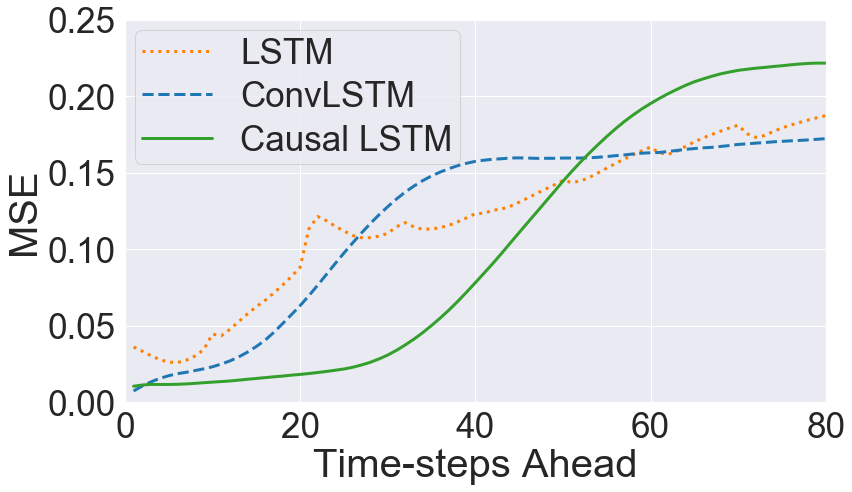

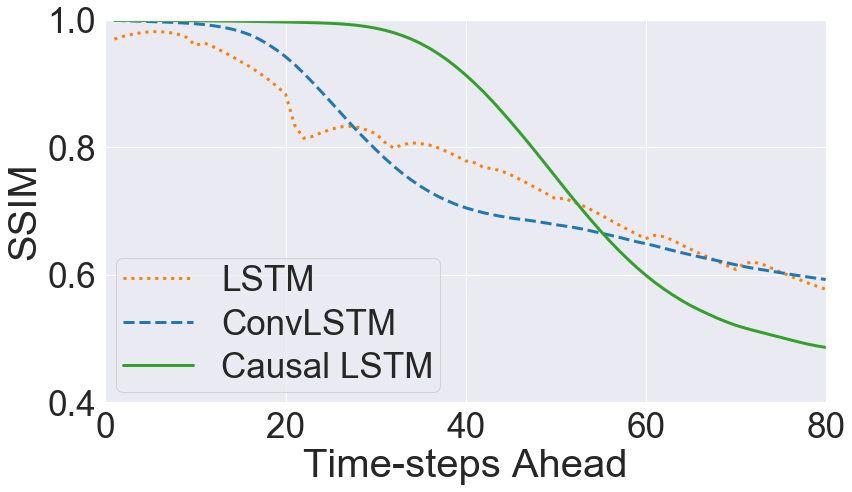

<Figure size 864x504 with 0 Axes>

In [43]:

test_set = 'Test'
baseline=''
metric = 'MSE'
evaluators_full = testset_exp_eval_full[test_set]
exps = {
    'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
    
            'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c': 'ConvLSTM',
            'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3': 'Causal LSTM'
}
ci = None

ff = 10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,7), 
            "lines.linewidth": 3,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})
# sns.set_context("paper", font_scale=1)

for metric in ['MSE', 'SSIM']:
    dfs = []
    dfss = None

    for exp, name in exps.items():
        print(exp)
        ev = evaluators_full[exp]



        x_title = 'Time-steps Ahead'
        y_title = metric

        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = name

        dfs.append(df)
        dfss = pd.concat(dfs)

    ll = len(exps)
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=None, palette=palette[:ll])

    ax.lines[0].set_linestyle(":")
    ax.lines[1].set_linestyle("--")


    if metric == 'MSE':
        ax.set_ylim([0, 0.2])
        plt.yticks([0, 0.05, 0.1, 0.15, .20, .25])
    else:
        ax.set_ylim([0.4, 1])

    ax.set_xlim([0, 80])

    handles, labels = ax.get_legend_handles_labels()
    handles[1].set_linestyle(":")
    handles[2].set_linestyle("--")
    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

    plt.tight_layout()

    plt.savefig('results/%s/causal_%s_%s.pdf' % (metric, metric,ci))
    plt.figure()

# ConvLSTM & PredRNN

In [44]:
dff[dff.dataset=='original'].index.values

array(['ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5',
       'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5_belated',
       'convlstm_batch_6_samples_5_in_5_out_20_normal_lr_0.001',
       'convlstm_batch_6_samples_5_in_5_out_20_normal_lr_0.001_belated',
       'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c',
       'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True_belated',
       'predrnn_batch_4_samples_5_in_5_out_40_normal_lr_0.0001

# Refeeding All

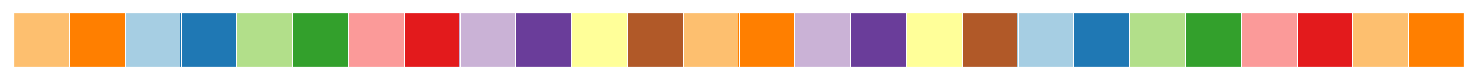

In [45]:
sns.palplot(paired)

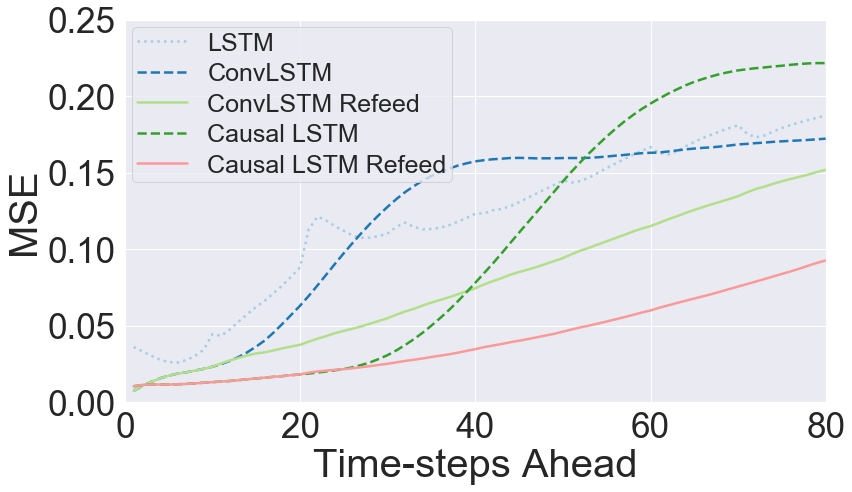

In [46]:
test_set = 'Test'
baselines=['']
metric = 'MSE'
evaluators_full = testset_exp_eval_full[test_set]
exps = {
    'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
#     'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5_belated' : 'LSTM',

    'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c': 'ConvLSTM',
'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM Refeed',
'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3': 'Causal LSTM',
'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM Refeed',
}

ci = None
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(12,7), 
            "lines.linewidth": 2.5,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

# fig = plt.figure(figsize=(12,18)).add_axes()
dfs = []
     
for exp, name in exps.items():
    ev = evaluators_full[exp]

    x_title = 'Time-steps Ahead'
    y_title = metric

    for baseline in baselines:
        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = name

        dfs.append(df)
        dfss = pd.concat(dfs)
ll = len(exps)
ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=ci, palette=paired[2:ll+2])

style0 = '-'
style1 = "--"
style2 = ":"
style3 = "-."

ax.lines[0].set_linestyle(style2)
ax.lines[1].set_linestyle(style1)
ax.lines[3].set_linestyle(style1)

# {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}

if metric == 'MSE':
    ax.set_ylim([0, 0.2])
    plt.yticks([0, 0.05, 0.1, 0.15, .20])

else:
    ax.set_ylim([0.5, 1])

ax.set_xlim([0, 80])


handles, labels = ax.get_legend_handles_labels()

handles[1].set_linestyle(style2)
handles[2].set_linestyle(style1)
handles[4].set_linestyle(style1)



handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

if metric == 'MSE':
    ax.set_ylim([0, 0.2])
    plt.yticks([0, 0.05, 0.1, 0.15, .20, .25])
else:
    ax.set_ylim([0.4, 1])
    
ax.set_xlim([0, 80])

plt.tight_layout()


plt.savefig('results/mse/refeed_all_%s_%s.pdf' % (metric,ci))
# plt.savefig('results/arlstm_%s.png' % metric

# Refeeding LSTM

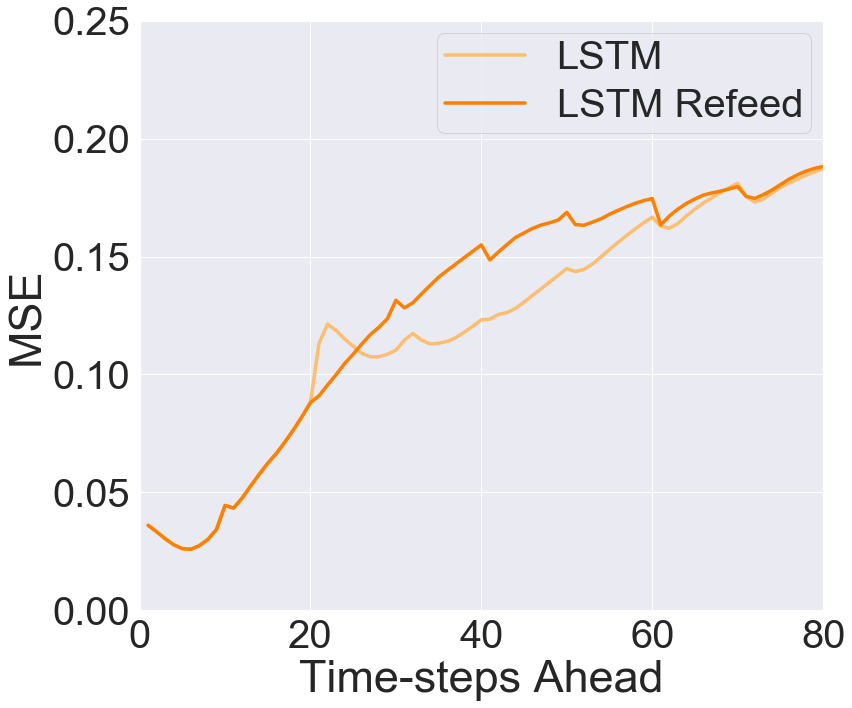

In [47]:
test_set = 'Test'
baselines=['']
metric = 'MSE'
evaluators_full = testset_exp_eval_full[test_set]
exps = {
    'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
    'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5_belated' : 'LSTM Refeed',

#     'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c': 'ConvLSTM',
# 'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM Refeed',
# 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3': 'Causal LSTM',
# 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM Refeed',
}

ci = None
sns.set(style="whitegrid")
ff=15
sns.set(rc={'figure.figsize':(12,10), 
            "lines.linewidth": 3.5,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

# fig = plt.figure(figsize=(12,18)).add_axes()
dfs = []
     
for exp, name in exps.items():
    ev = evaluators_full[exp]

    x_title = 'Time-steps Ahead'
    y_title = 'MSE'

    for baseline in baselines:
        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = name

        dfs.append(df)
        dfss = pd.concat(dfs)
ll = len(exps)
ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=ci, palette=
                  [paired[0], paired[1]])

style0 = '-'
style1 = "--"
style2 = ":"
style3 = "-."

# ax.lines[0].set_linestyle(style2)
# ax.lines[1].set_linestyle(style1)
# ax.lines[3].set_linestyle(style1)

# {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}

if metric == 'MSE':
    ax.set_ylim([0, 0.2])
    plt.yticks([0, 0.05, 0.1, 0.15, .20])

else:
    ax.set_ylim([0.5, 1])

ax.set_xlim([0, 80])


handles, labels = ax.get_legend_handles_labels()

# handles[1].set_linestyle(style2)
# handles[2].set_linestyle(style1)
# handles[4].set_linestyle(style1)



handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

if metric == 'MSE':
    ax.set_ylim([0, 0.2])
    plt.yticks([0, 0.05, 0.1, 0.15, .20, .25])
else:
    ax.set_ylim([0.4, 1])
    
ax.set_xlim([0, 80])


plt.tight_layout()


plt.savefig('results/mse/refeed_lstm_%s_%s.pdf' % (metric,ci))
# plt.savefig('results/arlstm_%s.png' % metric

# Refeed ConvLSTM

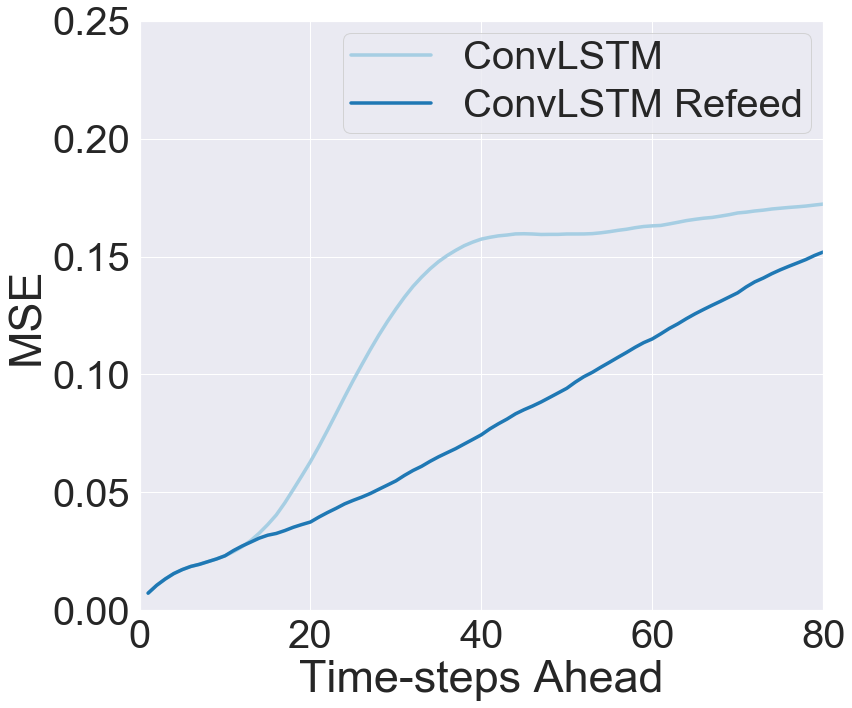

In [48]:
test_set = 'Test'
baselines=['']
metric = 'MSE'
evaluators_full = testset_exp_eval_full[test_set]
exps = {
#     'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
#     'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5_belated' : 'LSTM Refeed',

    'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c': 'ConvLSTM',
    'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM Refeed',

# 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3': 'Causal LSTM',
# 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM Refeed',
}

ci = None
ff=15
sns.set(rc={'figure.figsize':(12,10), 
            "lines.linewidth": 3.5,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

# fig = plt.figure(figsize=(12,18)).add_axes()
dfs = []
     
for exp, name in exps.items():
    ev = evaluators_full[exp]

    x_title = 'Time-steps Ahead'
    y_title = 'MSE'

    for baseline in baselines:
        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = name

        dfs.append(df)
        dfss = pd.concat(dfs)
ll = len(exps)
ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=ci, palette=paired[2:4])

style0 = '-'
style1 = "--"
style2 = ":"
style3 = "-."

# ax.lines[0].set_linestyle(style2)
# ax.lines[1].set_linestyle(style1)
# ax.lines[3].set_linestyle(style1)

# {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}

if metric == 'MSE':
    ax.set_ylim([0, 0.2])
    plt.yticks([0, 0.05, 0.1, 0.15, .20])

else:
    ax.set_ylim([0.5, 1])

ax.set_xlim([0, 80])


handles, labels = ax.get_legend_handles_labels()

# handles[1].set_linestyle(style2)
# handles[2].set_linestyle(style1)
# handles[4].set_linestyle(style1)



handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

if metric == 'MSE':
    ax.set_ylim([0, 0.2])
    plt.yticks([0, 0.05, 0.1, 0.15, .20, .25])
else:
    ax.set_ylim([0.4, 1])
    
ax.set_xlim([0, 80])



plt.tight_layout()

plt.savefig('results/mse/refeed_convlstm_%s_%s.pdf' % (metric,ci))
# plt.savefig('results/arlstm_%s.png' % metric

In [49]:
# Refeed Causal LSTM

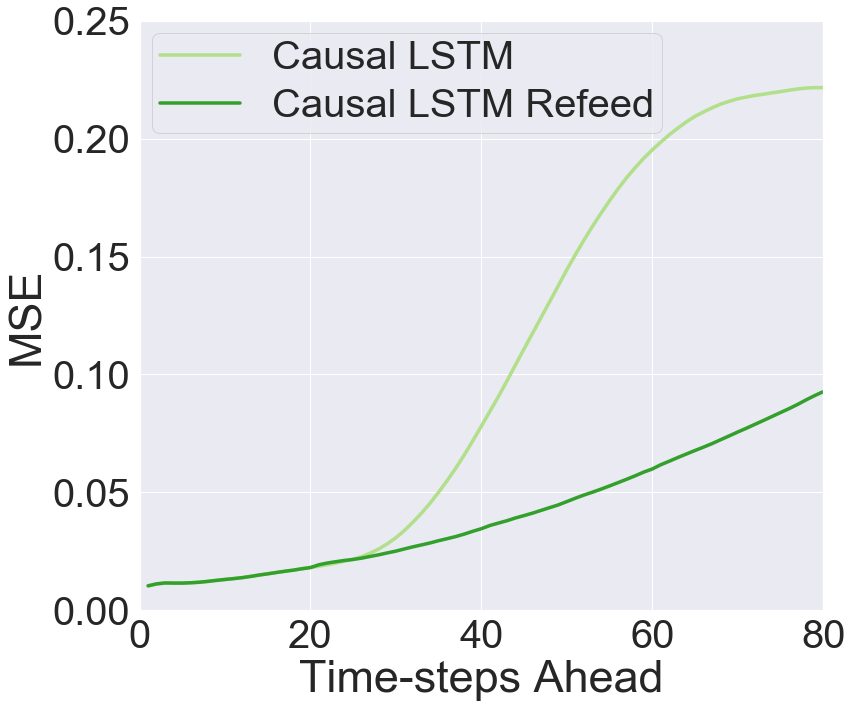

In [50]:
test_set = 'Test'
baselines=['']
metric = 'MSE'
evaluators_full = testset_exp_eval_full[test_set]
exps = {
#     'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
#     'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5_belated' : 'LSTM Refeed',

#     'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c': 'ConvLSTM',
#     'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM Refeed',

'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3': 'Causal LSTM',
'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM Refeed',
}

ci = None
ff=15
sns.set(rc={'figure.figsize':(12,10), 
            "lines.linewidth": 3.5,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

# fig = plt.figure(figsize=(12,18)).add_axes()
dfs = []
     
for exp, name in exps.items():
    ev = evaluators_full[exp]

    x_title = 'Time-steps Ahead'
    y_title = 'MSE'

    for baseline in baselines:
        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = name

        dfs.append(df)
        dfss = pd.concat(dfs)
ll = len(exps)
ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=ci, palette=paired[4:6])

style0 = '-'
style1 = "--"
style2 = ":"
style3 = "-."

# ax.lines[0].set_linestyle(style2)
# ax.lines[1].set_linestyle(style1)
# ax.lines[3].set_linestyle(style1)

# {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}

if metric == 'MSE':
    ax.set_ylim([0, 0.2])
    plt.yticks([0, 0.05, 0.1, 0.15, .20])

else:
    ax.set_ylim([0.5, 1])

ax.set_xlim([0, 80])


handles, labels = ax.get_legend_handles_labels()

# handles[1].set_linestyle(style2)
# handles[2].set_linestyle(style1)
# handles[4].set_linestyle(style1)



handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

if metric == 'MSE':
    ax.set_ylim([0, 0.2])
    plt.yticks([0, 0.05, 0.1, 0.15, .20, .25])
else:
    ax.set_ylim([0.4, 1])
    
ax.set_xlim([0, 80])


plt.tight_layout()

plt.savefig('results/mse/refeed_causal_%s_%s.pdf' % (metric,ci))
# plt.savefig('results/arlstm_%s.png' % metric

# Unet

ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5
predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated
unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7


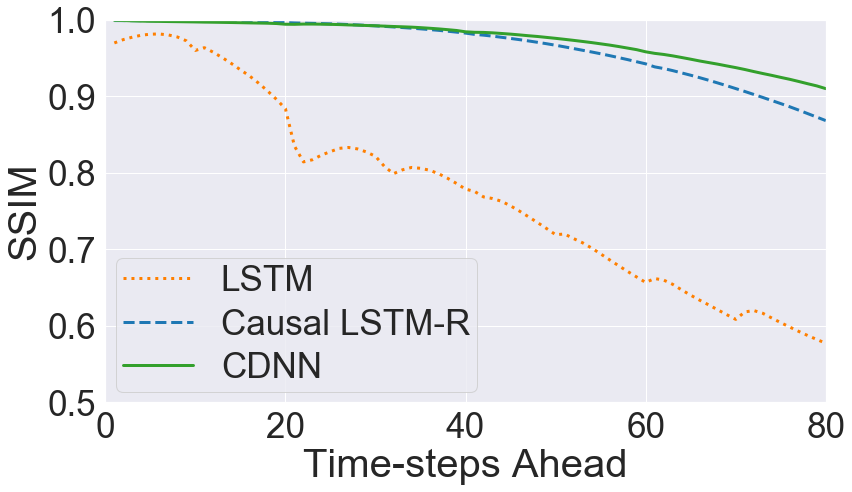

In [51]:

test_set = 'Test'
baseline=''
metric = 'SSIM'
evaluators_full = testset_exp_eval_full[test_set]
exps = {
    'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
    'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM-R',
           'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7':'CDNN'
}
ci = None
ff = 10
sns.set(rc={'figure.figsize':(12,7), 
            "lines.linewidth": 3,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

# fig = plt.figure(figsize=(12,18)).add_axes()
dfs = []
dfss = None
     
for exp, name in exps.items():
    print(exp)
    ev = evaluators_full[exp]



    x_title = 'Time-steps Ahead'
    y_title = metric

    all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
        y_title:              ev.state['%s_%sval' % (metric, baseline)],
        "type":               ev.state['%s_%shue' % (metric,baseline)]}
    df = pd.DataFrame.from_dict(all_data)
    df['Line'] = name

    dfs.append(df)
    dfss = pd.concat(dfs)

ll = len(exps)
ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=None, palette=palette[:ll])

ax.lines[0].set_linestyle(":")
ax.lines[1].set_linestyle('--')
# ax.lines[3].set_linestyle(style1)



if metric == 'MSE':
    ax.set_ylim([0, 0.2])
    plt.yticks([0, 0.05, 0.1, 0.15, .20, .2])
else:
    ax.set_ylim([0.5, 1])
    
ax.set_xlim([0, 80])

handles, labels = ax.get_legend_handles_labels()
handles[1].set_linestyle(":")
handles[2].set_linestyle("--")

ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

plt.tight_layout()

plt.savefig('results/%s/unet_%s_%s.pdf' % (metric, metric,ci))
# plt.savefig('results/arlstm_%s.png' % metric)

# Generalization

In [52]:
testset_exp_eval_full.keys()

dict_keys(['Test', 'Lines', 'Double_Drop', 'Illumination_135', 'Illumination_Random', 'Shallow_Depth', 'Smaller_Tub', 'Bigger_Tub', 'Fixed_Tub_10'])

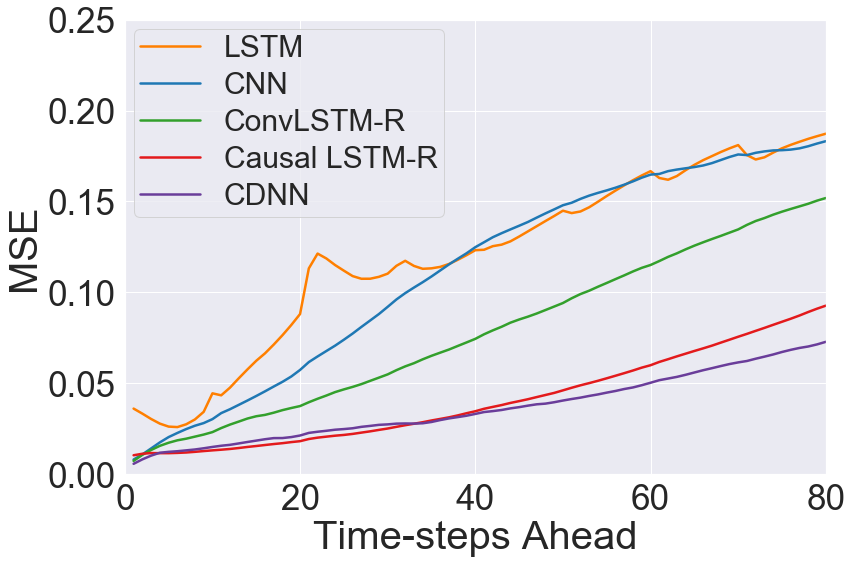

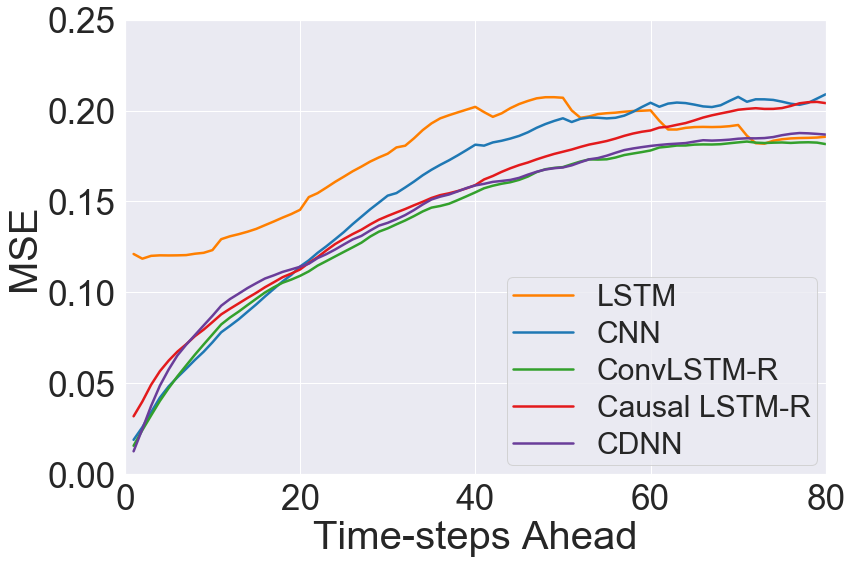

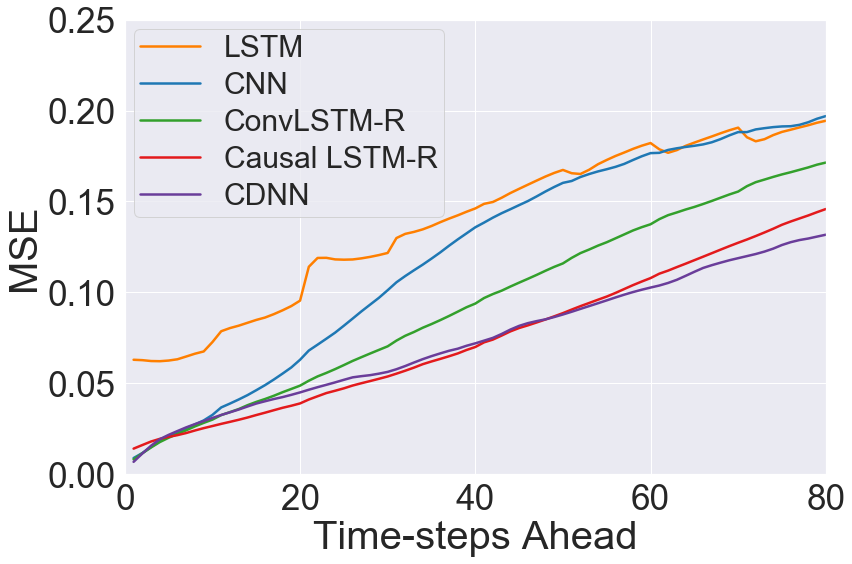

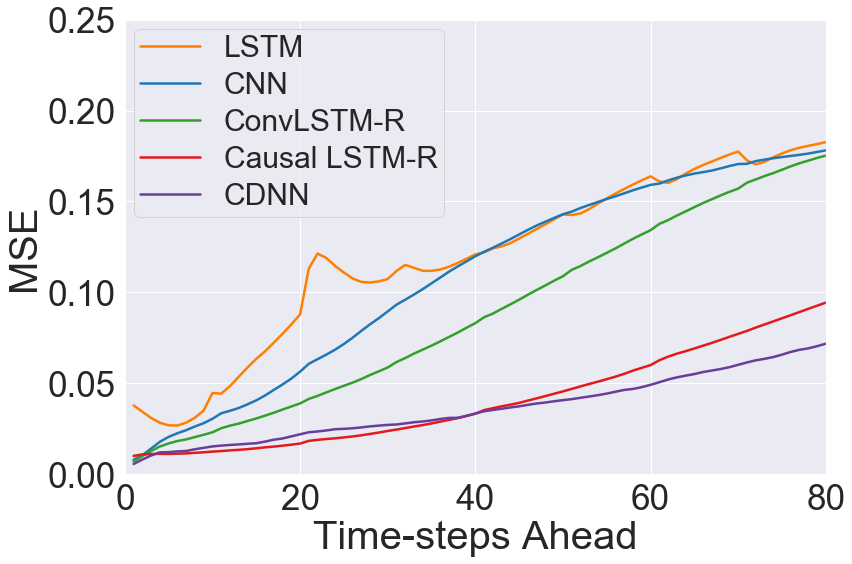

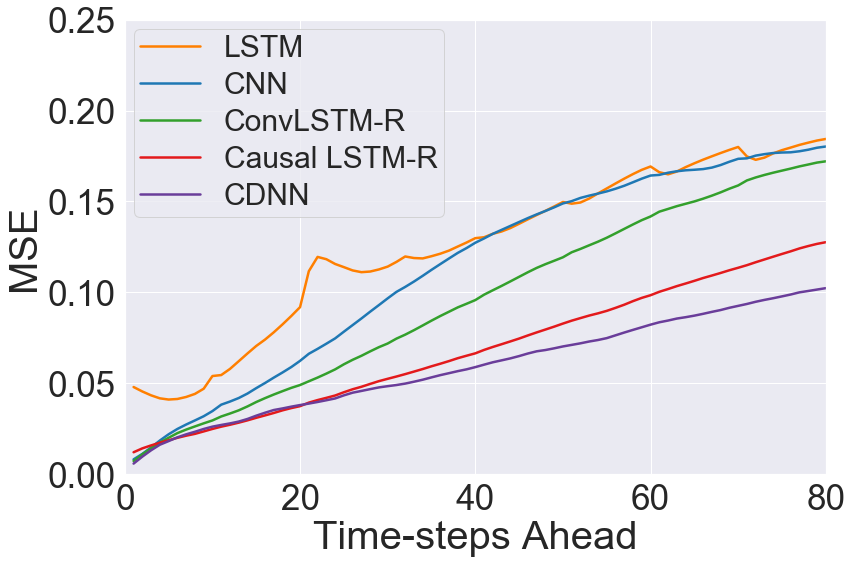

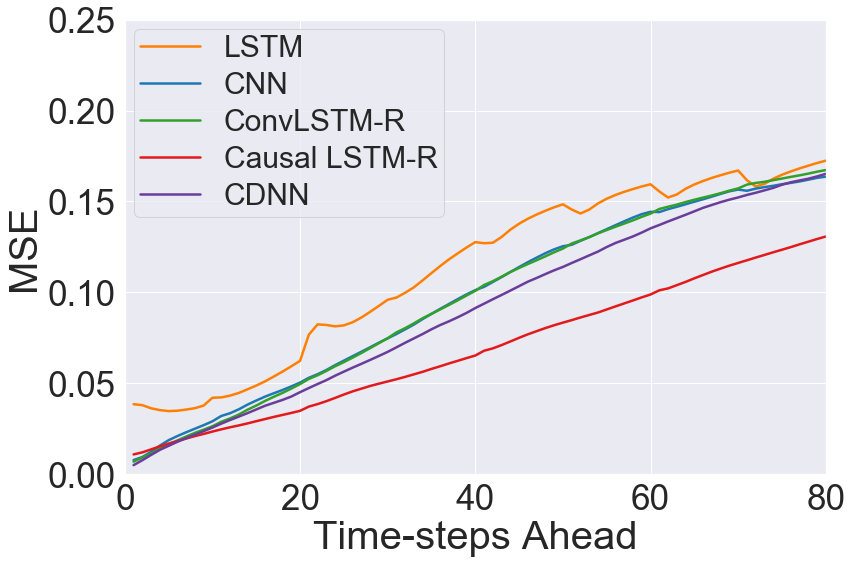

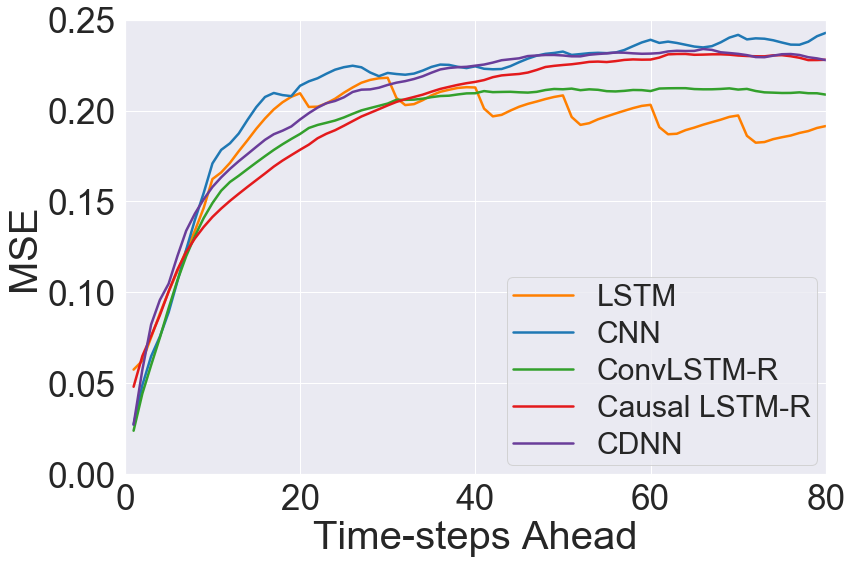

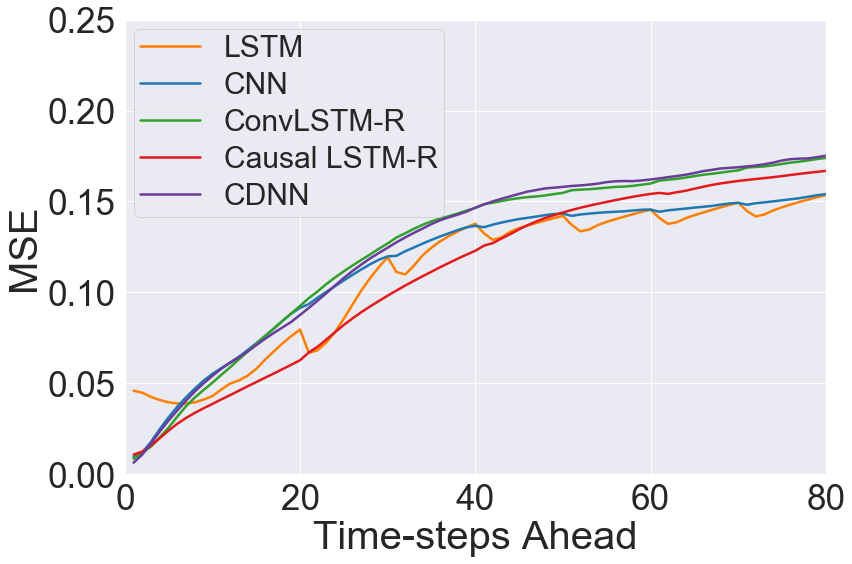

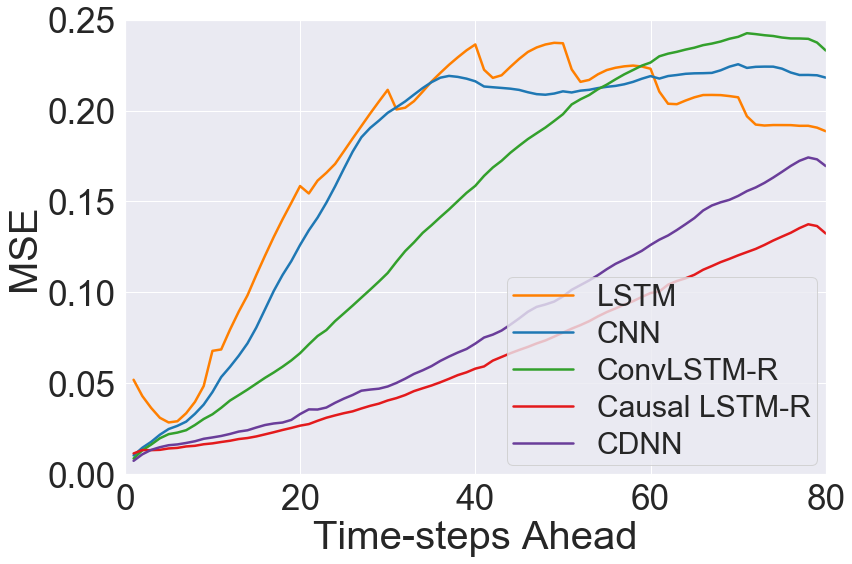

In [89]:
baselines=['']
metric = 'MSE'
exps = {
    'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
   'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7': 'CNN',
           'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM-R',
    'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM-R',
    'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7': 'CDNN'
}

ci = None
ff=10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8), 
            "lines.linewidth": 2.5,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff/2, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

for test_set in testset_exp_eval_full.keys():
    evaluators_full = testset_exp_eval_full[test_set]
    plt.figure()
    dfs = []
    for exp, name in exps.items():
        ev = evaluators_full[exp]

        x_title = 'Time-steps Ahead'
        y_title = metric

        for baseline in baselines:
            all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
                y_title:              ev.state['%s_%sval' % (metric, baseline)],
                "type":               ev.state['%s_%shue' % (metric,baseline)]}
            df = pd.DataFrame.from_dict(all_data)
            df['Line'] = name

            dfs.append(df)
            dfss = pd.concat(dfs)
    ll = len(exps)
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=ci, palette=palette[:ll])

    if metric == 'MSE':
        ax.set_ylim([0, 0.2])
        plt.yticks([0, 0.05, 0.1, 0.15, 0.20, .25])
    else:
#         ax.set_ylim([0, 1.05])
#         plt.yticks([float(a)/10 for a in list(range(11))])
        pass

    ax.set_xlim([0, 80])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

    plt.tight_layout()
    plt.plot()
    plt.savefig('results/generalization/test_set_%s_%s_%s.pdf' % (test_set, metric,ci))

# Back and forth

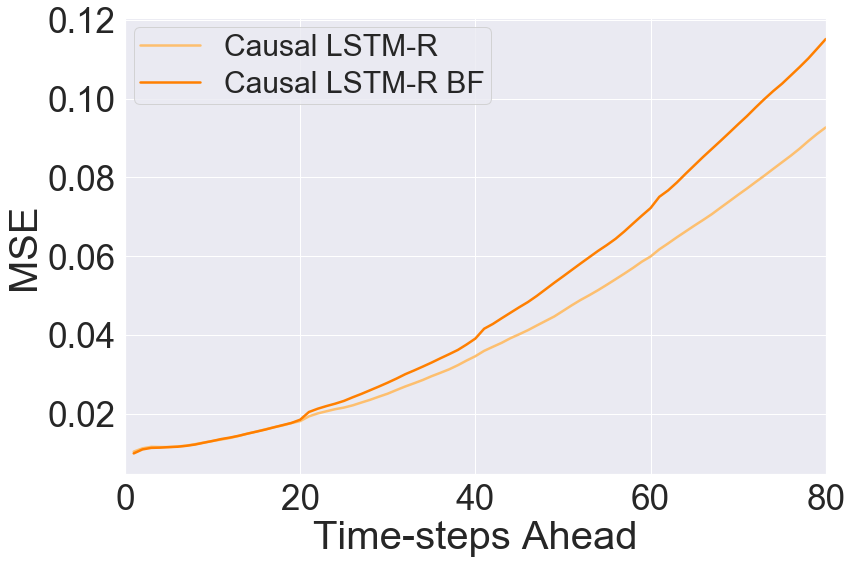

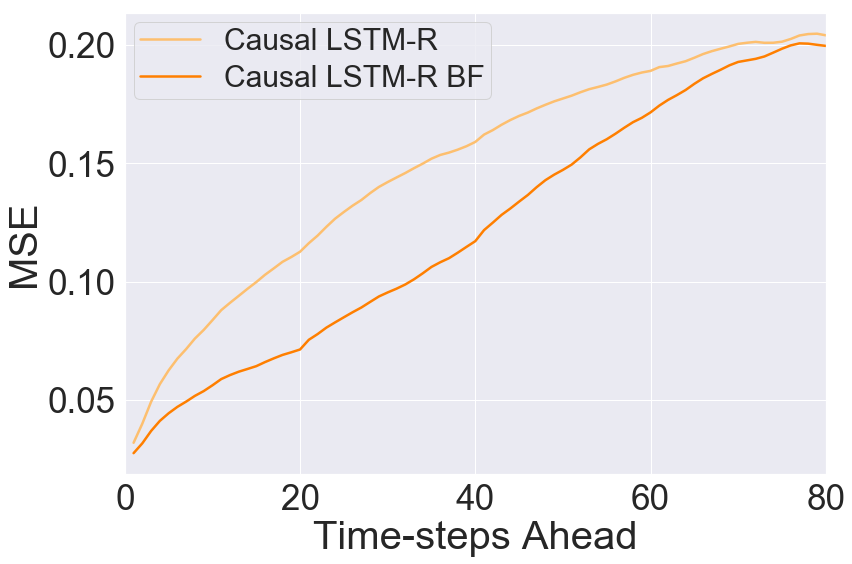

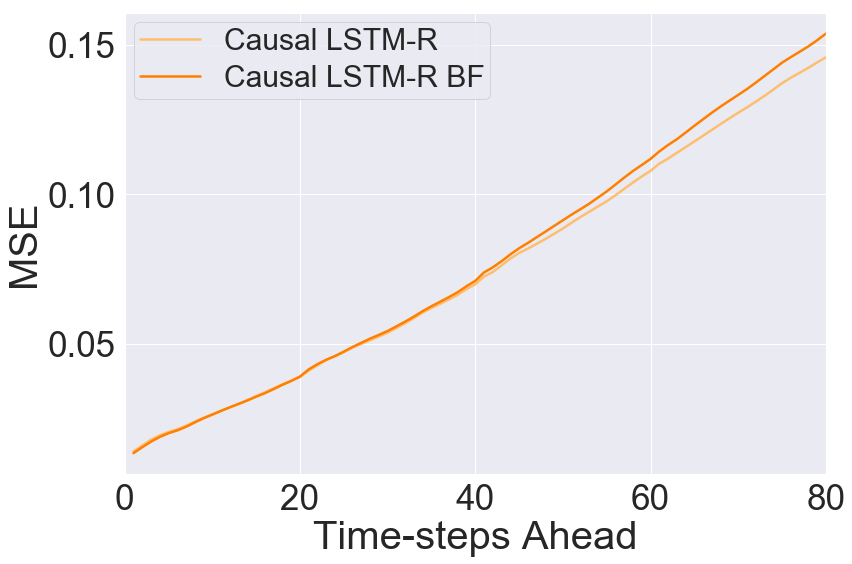

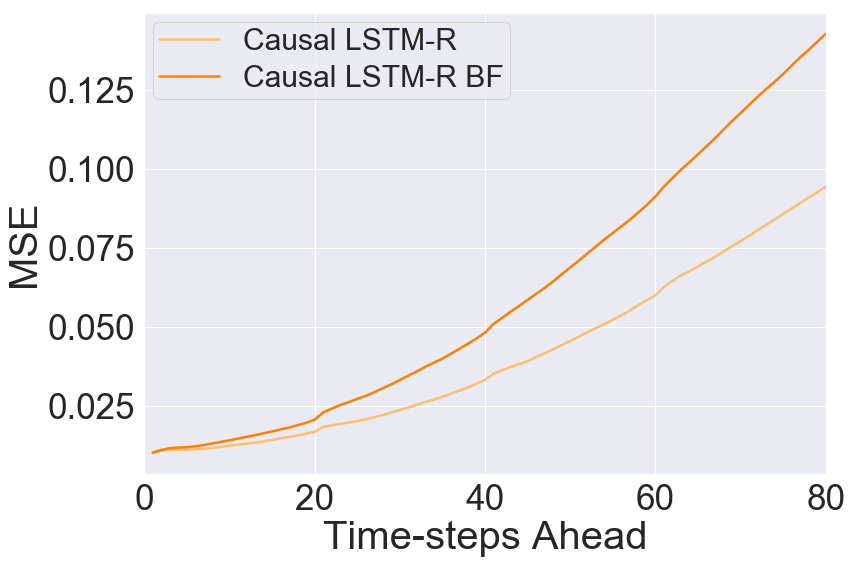

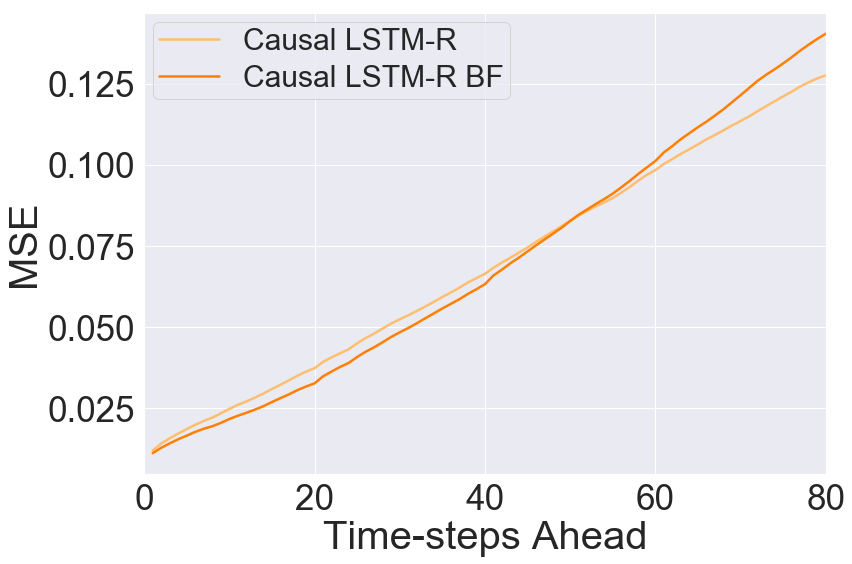

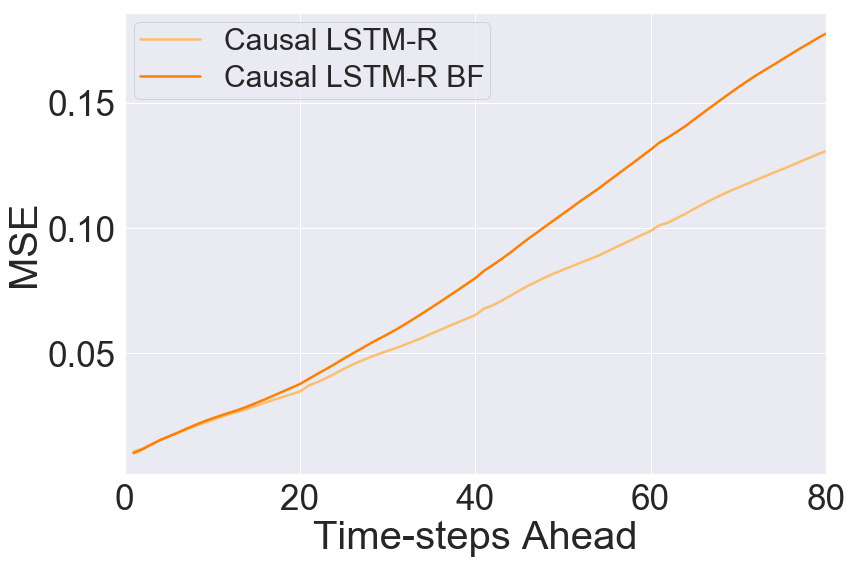

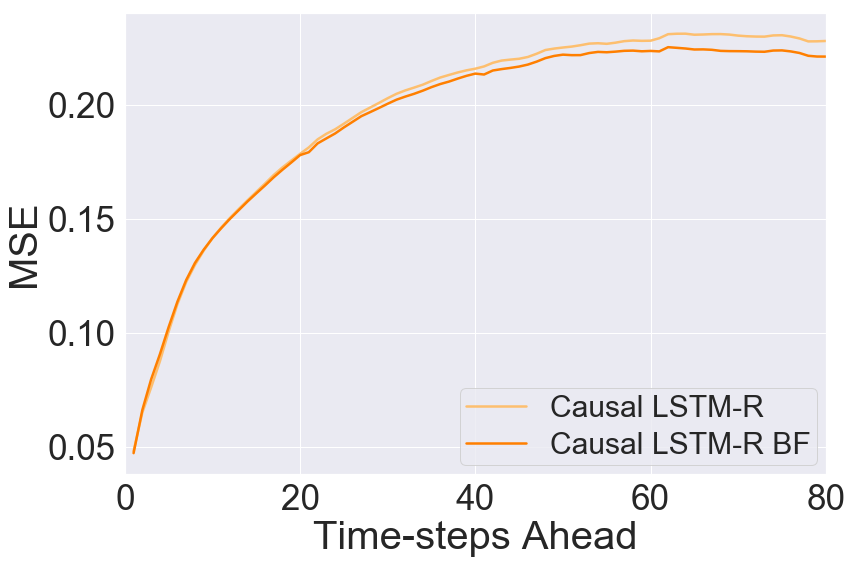

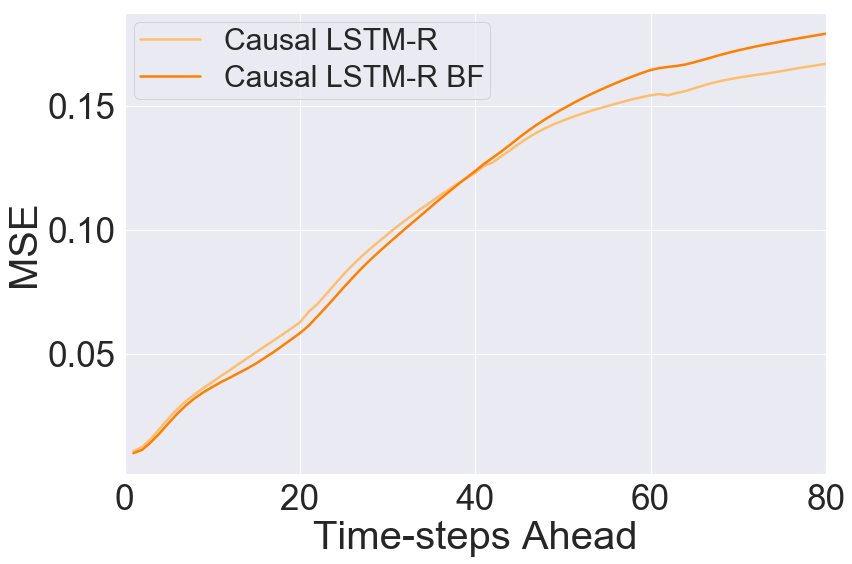

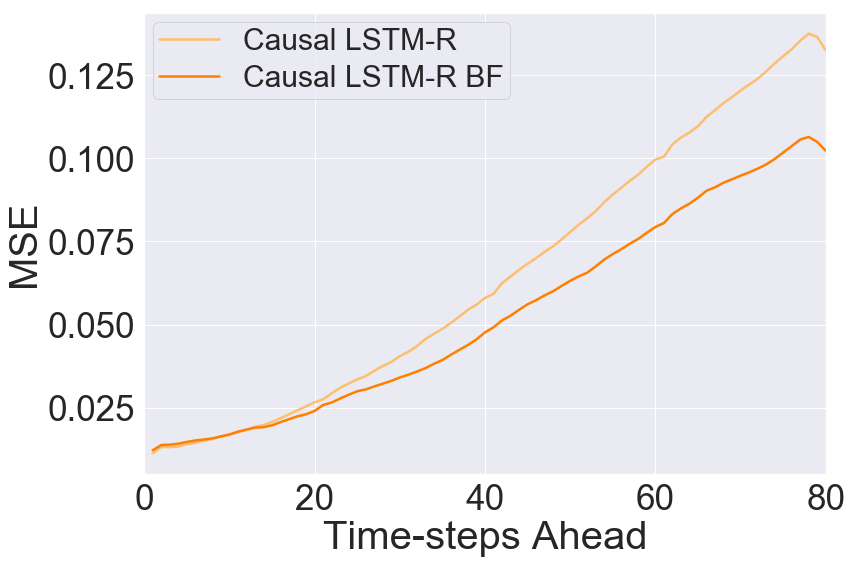

In [222]:
baselines=['']
metric = 'MSE'
exps = {
#     'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
#    'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7': 'CNN',
#            'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM-R',
'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM-R',
'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True_belated': 'Causal LSTM-R BF',
# 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7': 'CDNN',
# 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7_back_and_forth_True' : 'CDNN BF'
}

ci = None
ff=10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8), 
            "lines.linewidth": 2.5,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff/2, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

for test_set in testset_exp_eval_full.keys():
    evaluators_full = testset_exp_eval_full[test_set]
    plt.figure()
    dfs = []
    for exp, name in exps.items():
        ev = evaluators_full[exp]

        x_title = 'Time-steps Ahead'
        y_title = metric

        for baseline in baselines:
            all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
                y_title:              ev.state['%s_%sval' % (metric, baseline)],
                "type":               ev.state['%s_%shue' % (metric,baseline)]}
            df = pd.DataFrame.from_dict(all_data)
            df['Line'] = name

            dfs.append(df)
            dfss = pd.concat(dfs)
    ll = len(exps)
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=ci, palette=paired[:ll])

    if metric == 'MSE':
        pass
#         ax.set_ylim([0, 0.2])
#         plt.yticks([0, 0.05, 0.1, 0.15, 0.20, .25])
    else:
#         ax.set_ylim([0, 1.05])
#         plt.yticks([float(a)/10 for a in list(range(11))])
        pass

    ax.set_xlim([0, 80])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

    plt.tight_layout()
    plt.plot()
    plt.savefig('results/generalization/backforth_model_%s_test_set_%s_%s_%s.pdf' % (name, test_set, metric,ci))

# Back and forth

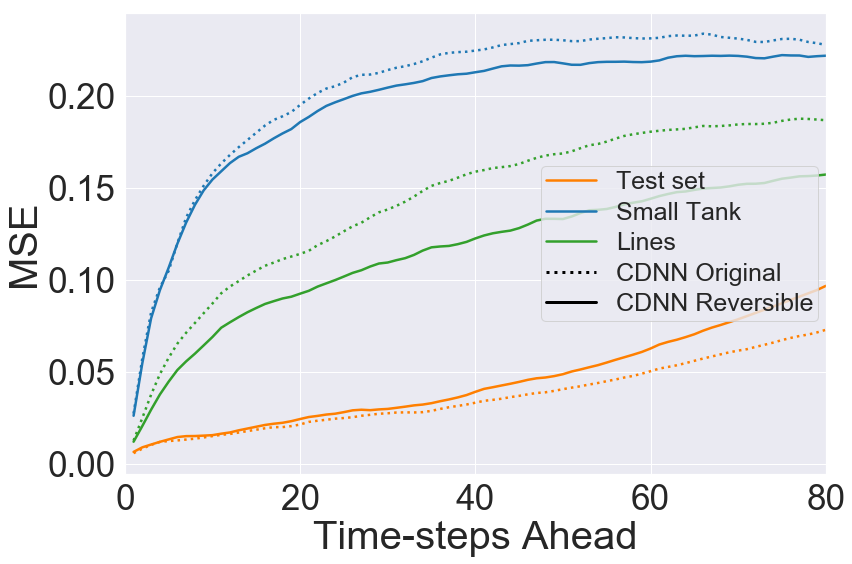

In [302]:
baseline=''
metric = 'MSE'
exps = {
#     'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
#    'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7': 'CNN',
#            'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM-R',
# 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM-R',
# 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True_belated': 'Causal LSTM-R BF',
'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7': 'CDNN Original',
'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7_back_and_forth_True' : 'CDNN BF'
}

ci = None
ff=10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8), 
            "lines.linewidth": 2.5,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

dfs = []
test_sets=['Test', 'Smaller_Tub', 'Lines']
for exp, name in exps.items():
    for test_set in test_sets:
# testset_exp_eval_full.keys():
#     print(test_set)
        evaluators_full = testset_exp_eval_full[test_set]
        ev = evaluators_full[exp]

        x_title = 'Time-steps Ahead'
        y_title = metric

        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
#         print('name ',name)
        df['Line'] = testset_names[test_set] +(' BF' if 'BF' in name else '')

        dfs.append(df)
        
dfss = pd.concat(dfs)
ll = len(test_sets)
ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=ci, palette=paired[1:7:2]*2)

if metric == 'MSE':
    pass
#         ax.set_ylim([0, 0.2])
#         plt.yticks([0, 0.05, 0.1, 0.15, 0.20, .25])
else:
#         ax.set_ylim([0, 1.05])
#         plt.yticks([float(a)/10 for a in list(range(11))])
    pass

ax.set_xlim([0, 80])

ax.lines[0].set_linestyle(":")
ax.lines[1].set_linestyle(':')
ax.lines[2].set_linestyle(':')
# ax.lines[3].set_linestyle(':')


handles, labels = ax.get_legend_handles_labels()
handles[1].set_linestyle(":")
handles[2].set_linestyle(':')
handles[3].set_linestyle(':')
# handles[4].set_linestyle(':')

# from matplotlib.lines import Line2D
lstyles = [':', '-']
lines = [Line2D([0], [0], color='black', linewidth=3, linestyle=c) for c in lstyles]
labels2 = ['CDNN Original', 'CDNN Reversible']
ax.legend(handles=handles[4:8]+lines, labels=labels[1:4]+labels2, loc='best', ncol=1)

# plt.legend(lines, labels)

plt.tight_layout()
plt.plot() 
plt.savefig('results/generalization/backforth_test_all_%s_%s.pdf' % (metric,ci))

# Fixed tank

In [279]:
experiments

['ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_5',
 'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5',
 'convlstm_batch_6_samples_5_in_5_out_20_normal_lr_0.001',
 'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c',
 'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_dataset_fixed_tub_24h_patience_5',
 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_3',
 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3',
 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True',
 'predrnn_batch_4_samples_5_in_5_out_40_normal_lr_0.0001_dataset_original_24h_patience_3',
 'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_fixed_tub_24h_patience_7',
 'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7',
 'resnet_dila

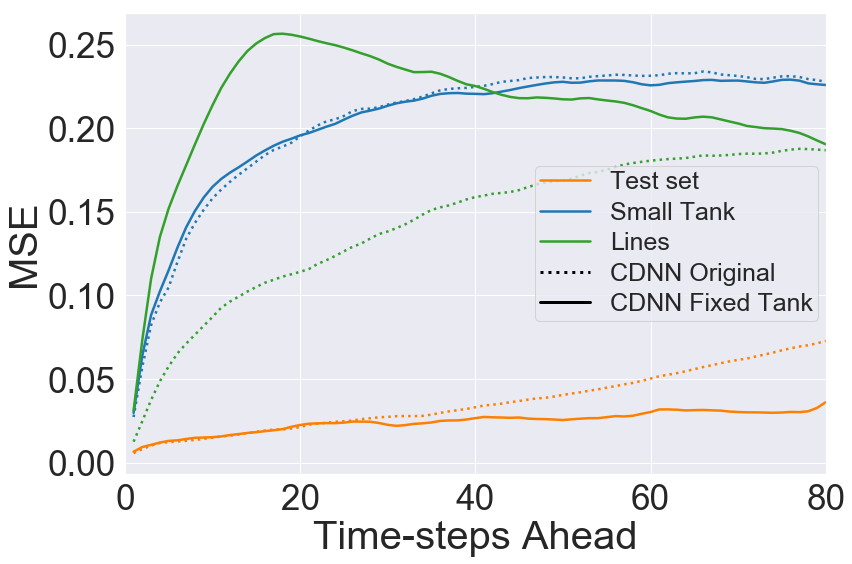

In [298]:
baseline=''
metric = 'MSE'
exps = {
#     'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
#    'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7': 'CNN',
#            'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM-R',
# 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM-R',
# 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True_belated': 'Causal LSTM-R BF',
'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7': 'CDNN',
# 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7_back_and_forth_True' : 'CDNN BF'
     'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_7': 'CDNN BF'
}

ci = None
ff=10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8), 
            "lines.linewidth": 2.5,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

dfs = []
test_sets=['Test', 'Smaller_Tub', 'Lines']
for exp, name in exps.items():
    for test_set in test_sets:
# testset_exp_eval_full.keys():
#     print(test_set)
        evaluators_full = testset_exp_eval_full[test_set]
        ev = evaluators_full[exp]

        x_title = 'Time-steps Ahead'
        y_title = metric

        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
#         print('name ',name)
        df['Line'] = testset_names[test_set] +(' BF' if 'BF' in name else '')

        dfs.append(df)
        
dfss = pd.concat(dfs)
ll = len(test_sets)
ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=ci, palette=paired[1:7:2]*2)

if metric == 'MSE':
    pass
#         ax.set_ylim([0, 0.2])
#         plt.yticks([0, 0.05, 0.1, 0.15, 0.20, .25])
else:
#         ax.set_ylim([0, 1.05])
#         plt.yticks([float(a)/10 for a in list(range(11))])
    pass

ax.set_xlim([0, 80])

ax.lines[0].set_linestyle(":")
ax.lines[1].set_linestyle(':')
ax.lines[2].set_linestyle(':')
# ax.lines[3].set_linestyle(':')


handles, labels = ax.get_legend_handles_labels()
handles[1].set_linestyle(":")
handles[2].set_linestyle(':')
handles[3].set_linestyle(':')
# handles[4].set_linestyle(':')

# from matplotlib.lines import Line2D
lstyles = [':', '-']
lines = [Line2D([0], [0], color='black', linewidth=3, linestyle=c) for c in lstyles]
labels2 = ['CDNN Original', 'CDNN Fixed Tank']
ax.legend(handles=handles[4:8]+lines, labels=labels[1:4]+labels2, loc='best', ncol=1)

# plt.legend(lines, labels)

plt.tight_layout()
plt.plot()
plt.savefig('results/generalization/ft_test_all_%s_%s.pdf' % (metric,ci))

# All models generalization

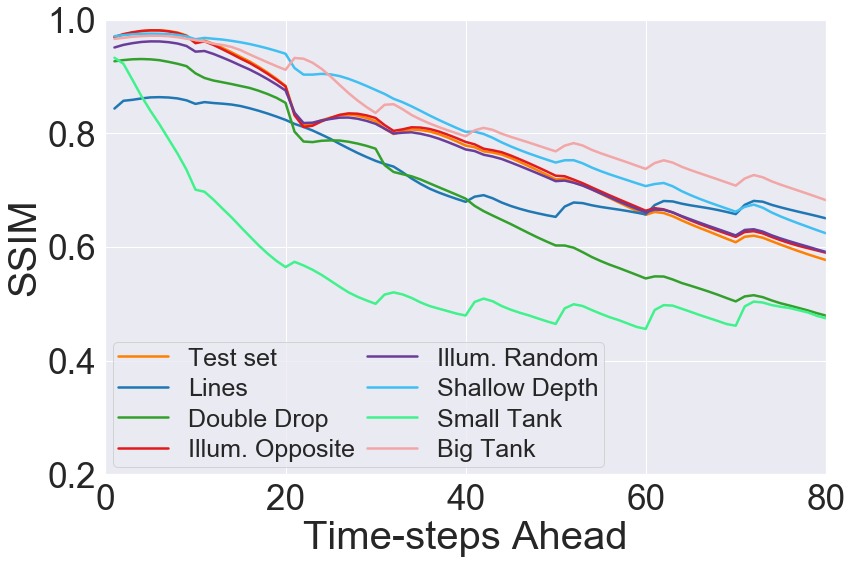

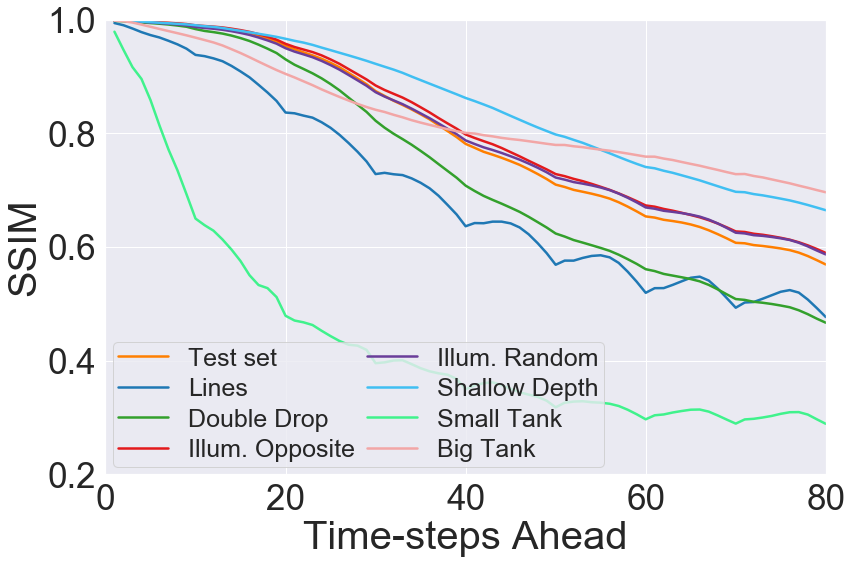

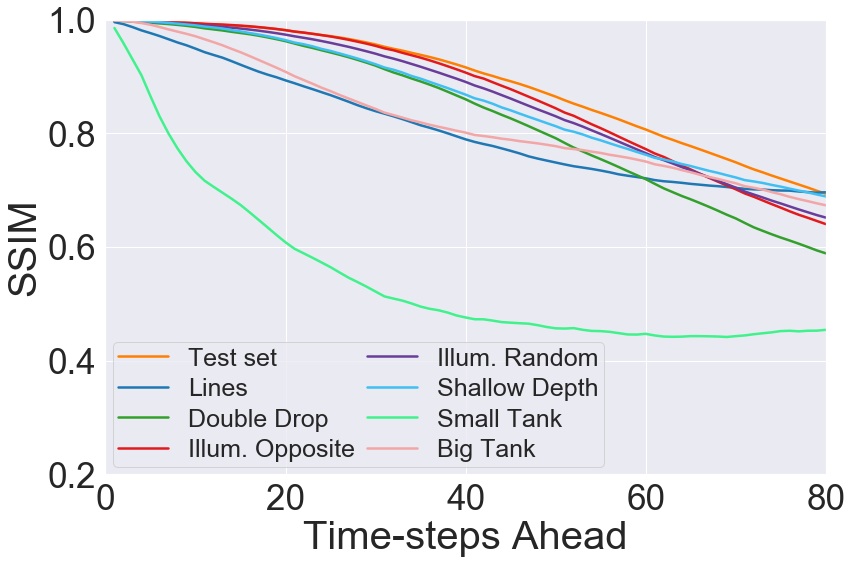

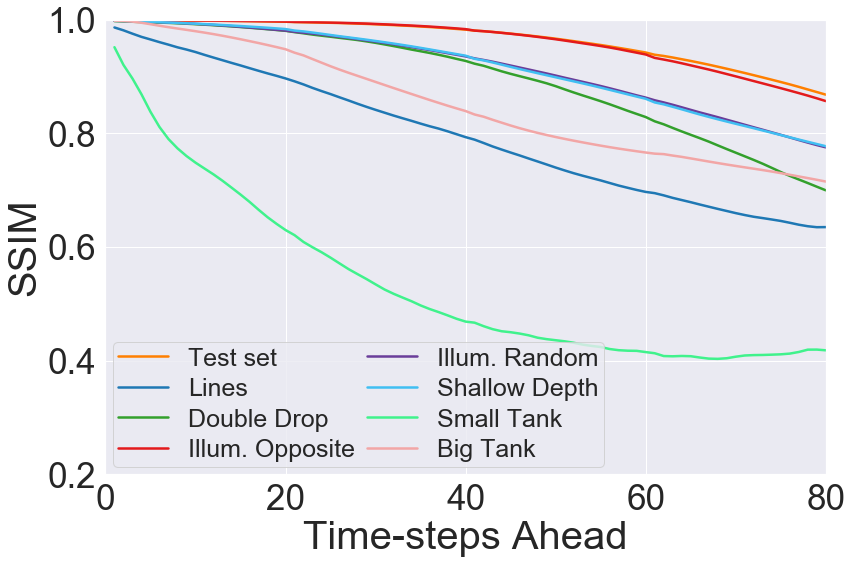

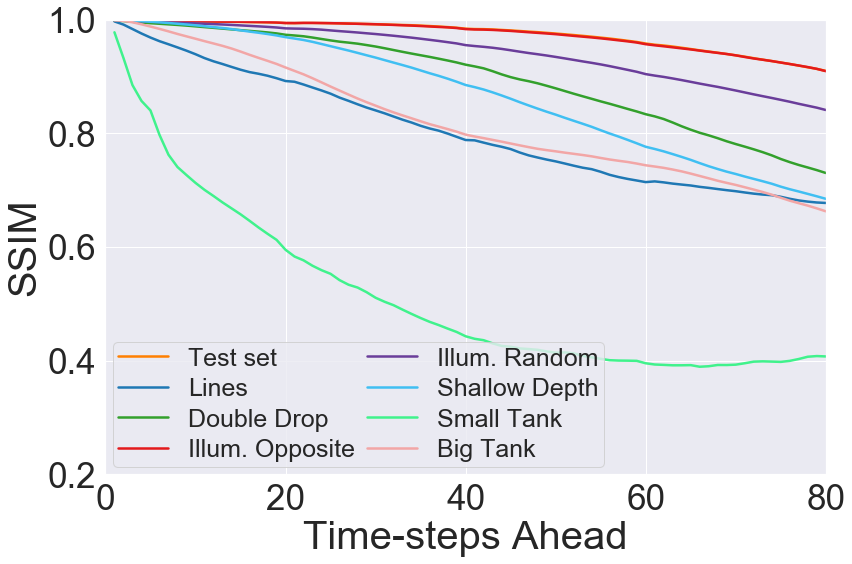

In [296]:

testset_names = {'Test': 'Test set', 
                 'Lines': 'Lines', 
                 'Double_Drop': 'Double Drop', 
                 'Illumination_135': 'Illum. Opposite', 
                 'Illumination_Random' : 'Illum. Random',
                 'Shallow_Depth': 'Shallow Depth', 
                 'Smaller_Tub': 'Small Tank', 
                 'Bigger_Tub': 'Big Tank',
                'Fixed_Tub_10':'Fixed Tank'
                }

metric = 'SSIM'
exps = {
    'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
   'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7': 'CNN',
'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM-R',
'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM-R',
# 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_3_belated':'Causal LSTM-R Fixed Tank',
# 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True_belated': 'Causal LSTM-R Back Forth',
'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7': 'CDNN',
# 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_7': 'CDNN Fixed Tank',
# 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7_back_and_forth_True': 'CDNN Back Forth',
}

ci = None
ff=10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8), 
            "lines.linewidth": 2.5,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})


for exp, name in exps.items():
    dfs = []
    dfss = None

    plt.figure()
    for test_set in list(testset_exp_eval_full.keys())[:-1]:
        evaluators_full = testset_exp_eval_full[test_set]
        ev = evaluators_full[exp]

        x_title = 'Time-steps Ahead'
        y_title = metric

        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               testset_names[test_set]
                 }
        df = pd.DataFrame.from_dict(all_data)

        dfs.append(df)
        dfss = pd.concat(dfs)

    ll = len(dfss.type.unique())
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="type", data=dfss, ax=fig, ci=ci , palette=palette[:ll])

    if metric == 'MSE':
        ax.set_ylim([0, 0.26])
        plt.yticks([0, 0.05, 0.1, 0.15, 0.20,.25])
    else:
        ax.set_ylim([0.2, 1])

    ax.set_xlim([0, 80])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=2)

    plt.tight_layout()
    plt.savefig('results/generalization/all_sets_%s_%s_%s.pdf' % (name, metric,ci))

# Fixed tank vs normal

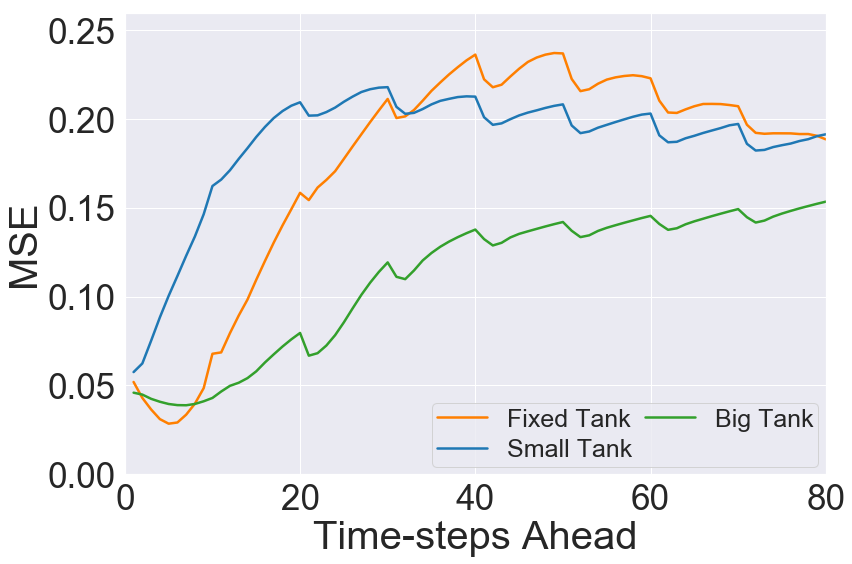

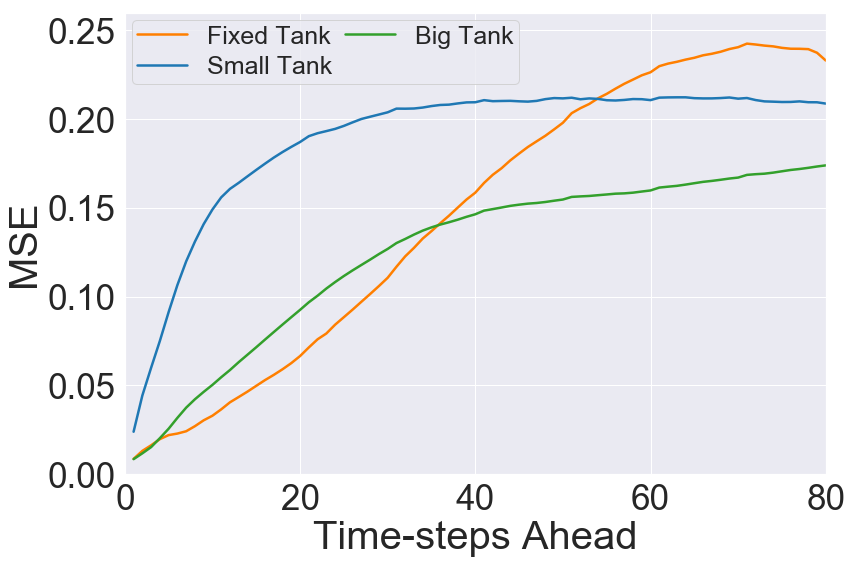

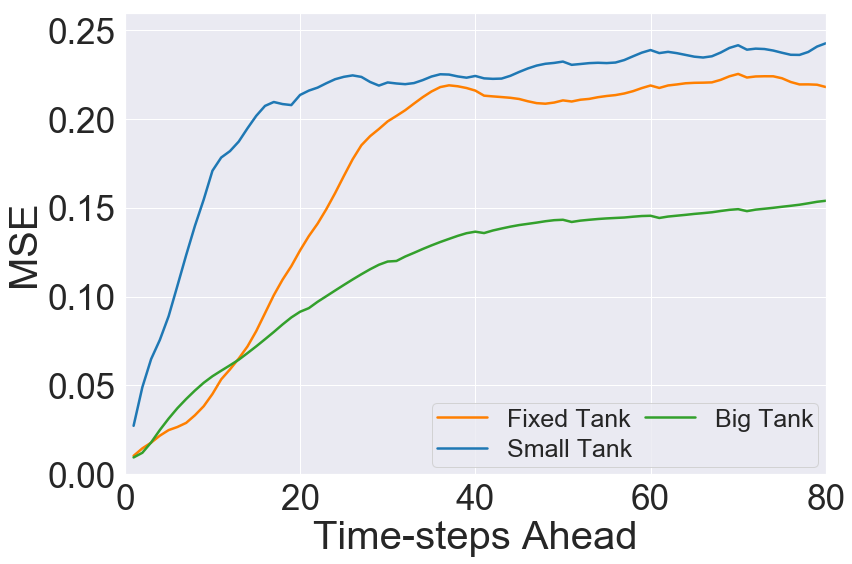

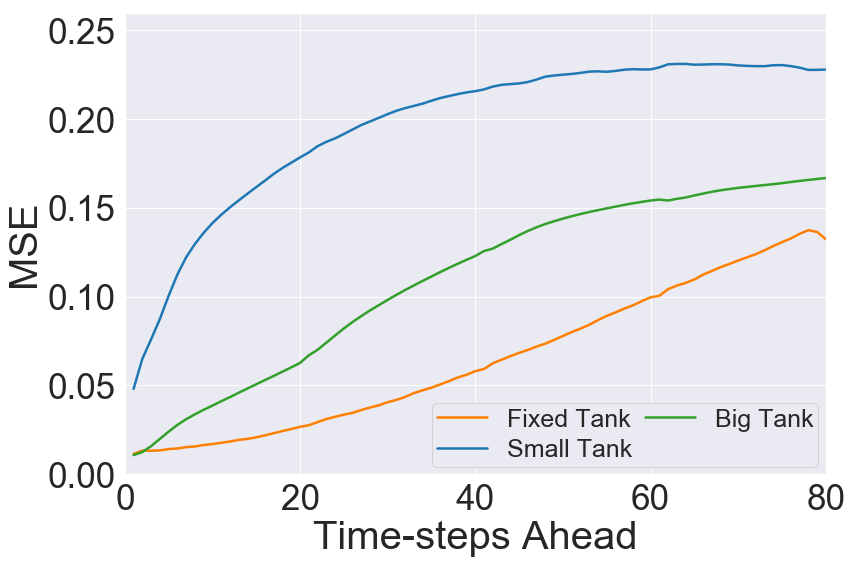

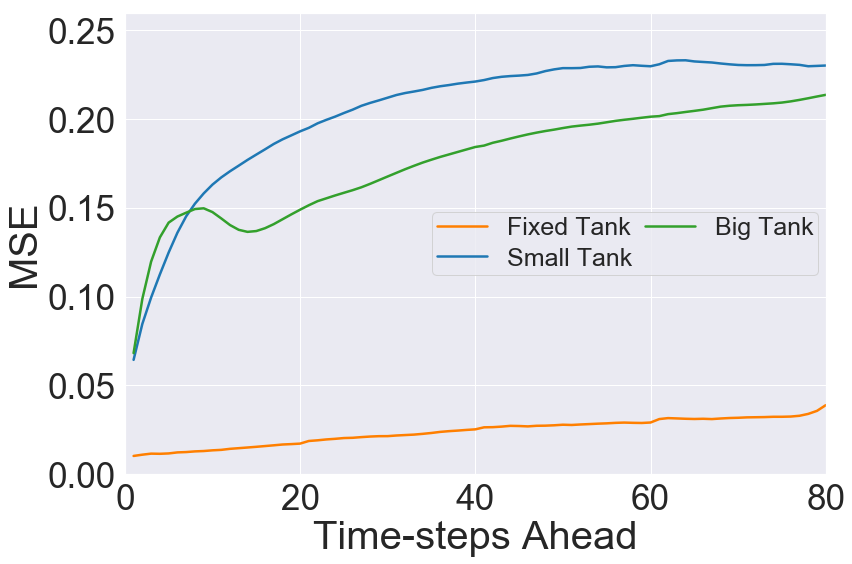

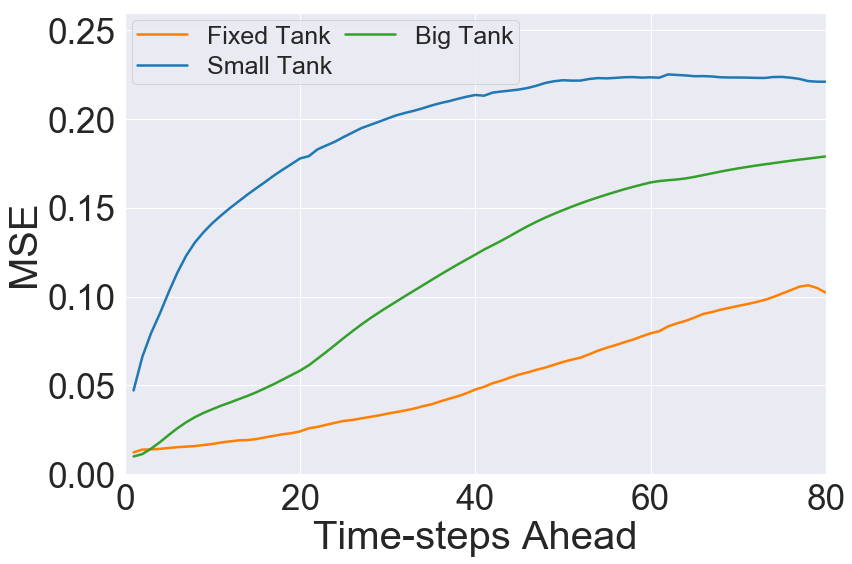

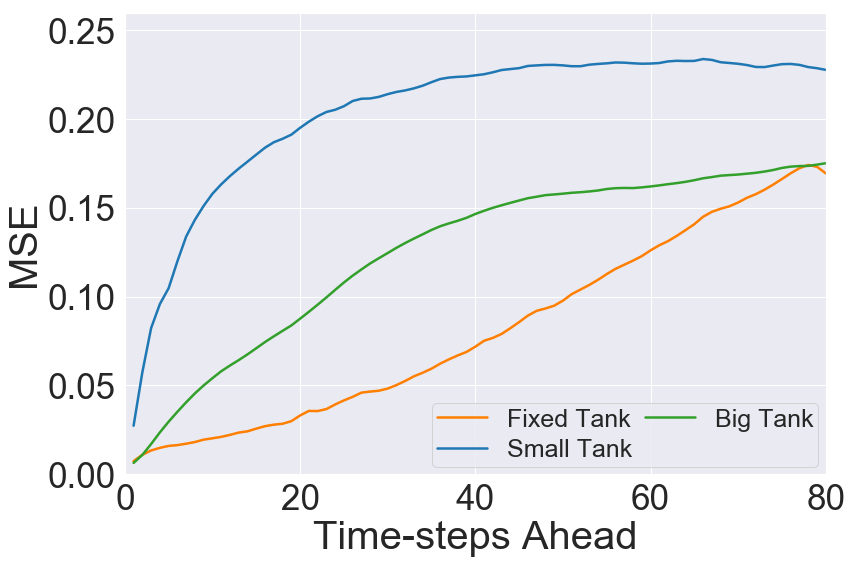

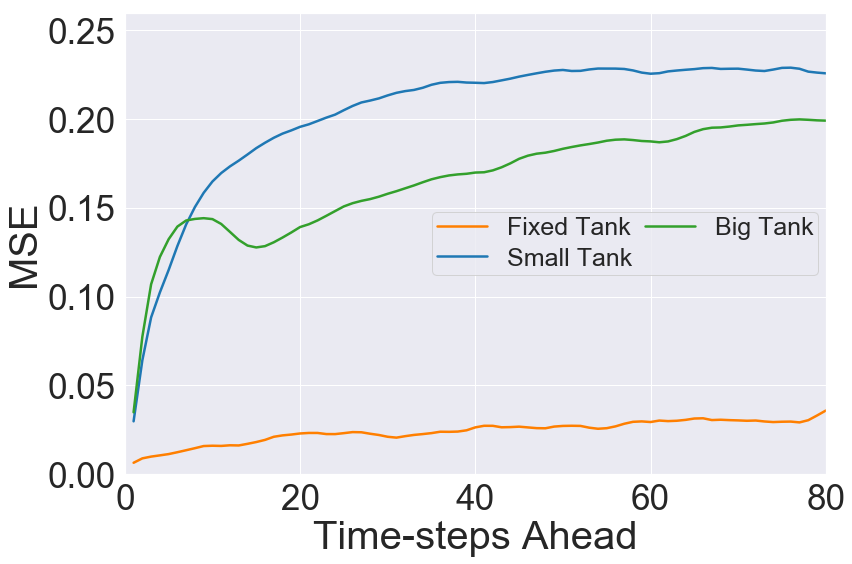

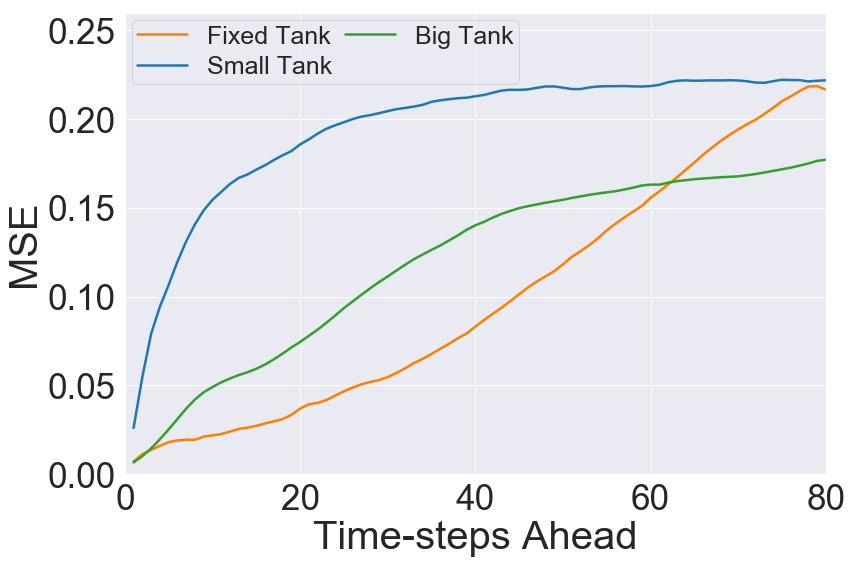

In [101]:
testset_names = { #'Test': 'Original', 
                 'Fixed_Tub_10': 'Fixed Tank',
                 'Smaller_Tub': 'Small Tank', 
                 'Bigger_Tub': 'Big Tank'
                }

baselines=['']
metric = 'MSE'
exps = {
    'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5' : 'LSTM',
           'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated': 'ConvLSTM-R',
   'resnet_dilated_batch_16_samples_5_in_5_out_10_normal_lr_0.0001_dataset_original_24h_patience_7': 'CNN',
'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM-R',
'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_3_belated':'Causal LSTM-R Fixed Tank',
'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_back_and_forth_True_belated': 'Causal LSTM-R Back Forth',
'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7': 'CDNN',
'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_24h_patience_7': 'CDNN Fixed Tank',
'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7_back_and_forth_True': 'CDNN Back Forth',
}

ci = None
sns.set(style="whitegrid")

ff=10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8), 
            "lines.linewidth": 2.5,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})



for exp, name in exps.items():
    dfs = []
#     exp = 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated'
#     name = 'predrnn'

    plt.figure()
    for test_set in testset_names.keys():
        evaluators_full = testset_exp_eval_full[test_set]
        ev = evaluators_full[exp]

        x_title = 'Time-steps Ahead'
        y_title = metric

        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               testset_names[test_set]
                 }
        df = pd.DataFrame.from_dict(all_data)

        dfs.append(df)
        dfss = pd.concat(dfs)

    ll = len(dfss.type.unique())
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="type", data=dfss, ax=fig, ci=ci, palette=palette[:ll])

    if metric == 'MSE':
        ax.set_ylim([0, 0.26])
        plt.yticks([0, 0.05, 0.1, 0.15, 0.20,.25])
    else:
        ax.set_ylim([0.2, 1])

    ax.set_xlim([0, 80])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=2)
    #     plt.title(test_set)

    plt.tight_layout()
    plt.savefig('results/generalization/ft_all_sets_%s_%s_%s.pdf' % (name, metric,ci))

# Wave speed

In [102]:
testset_exp_eval_full.keys()

dict_keys(['Test', 'Lines', 'Double_Drop', 'Illumination_135', 'Illumination_Random', 'Shallow_Depth', 'Smaller_Tub', 'Bigger_Tub', 'Fixed_Tub_10'])

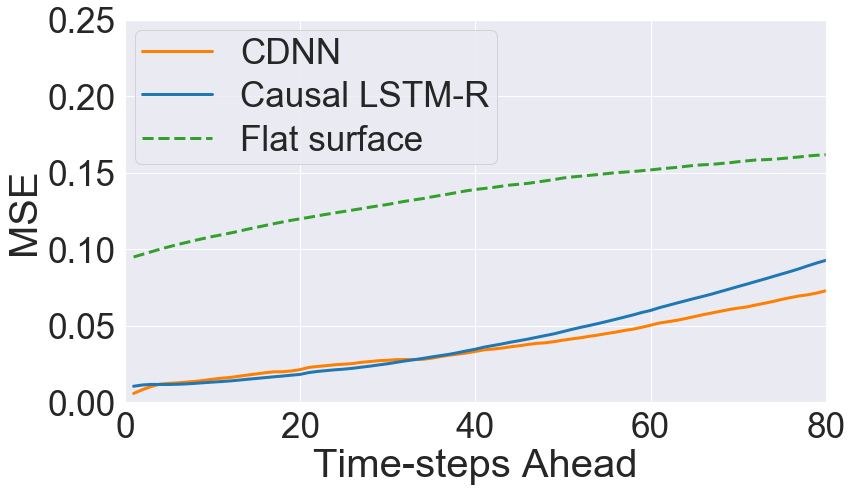

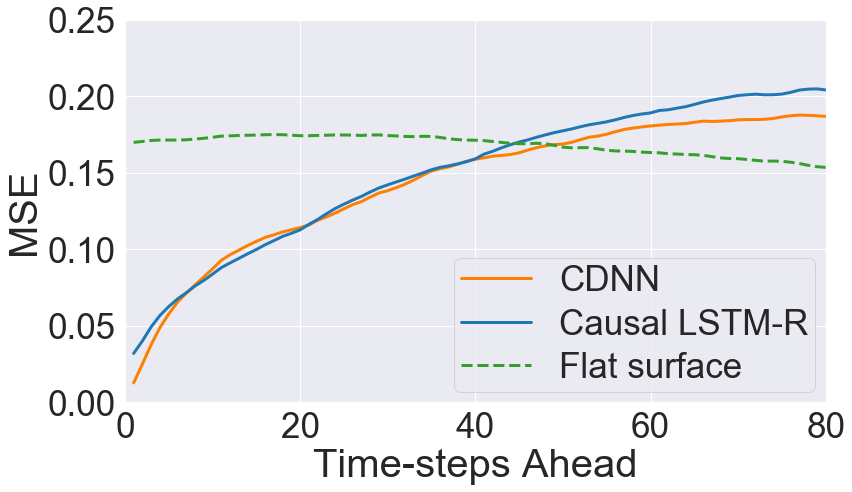

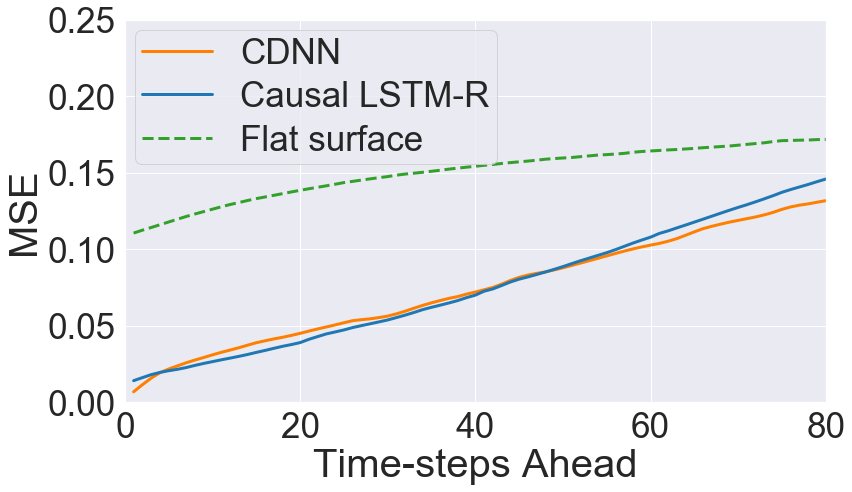

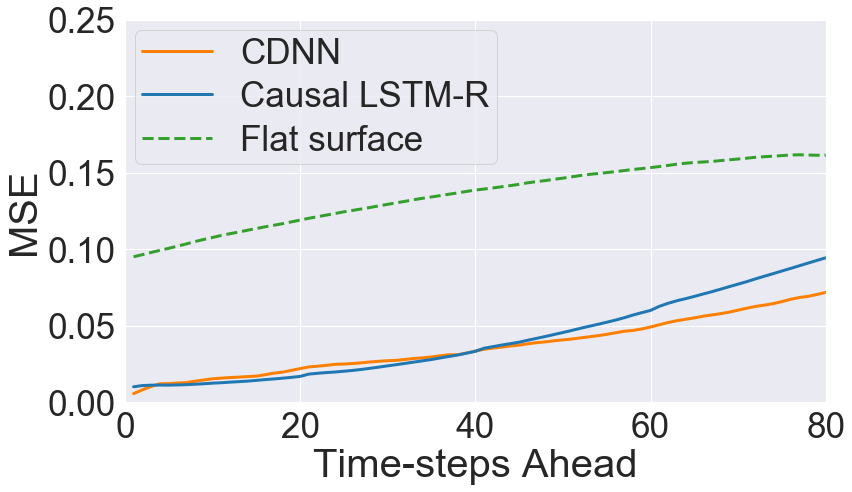

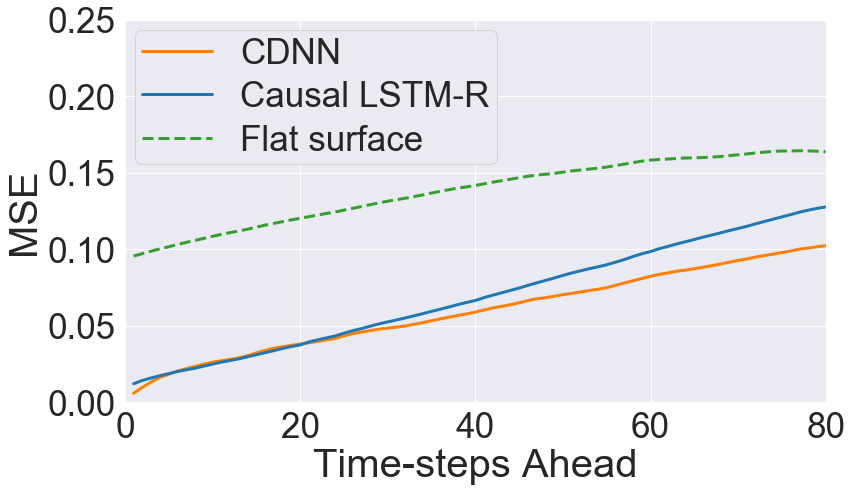

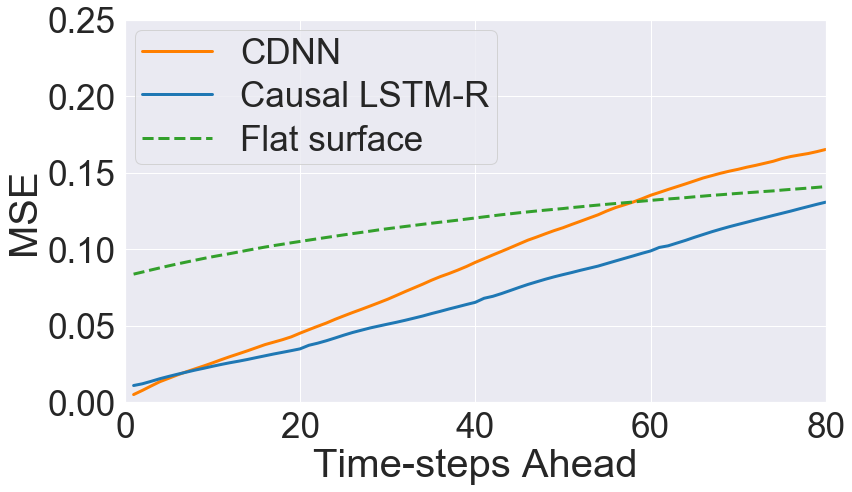

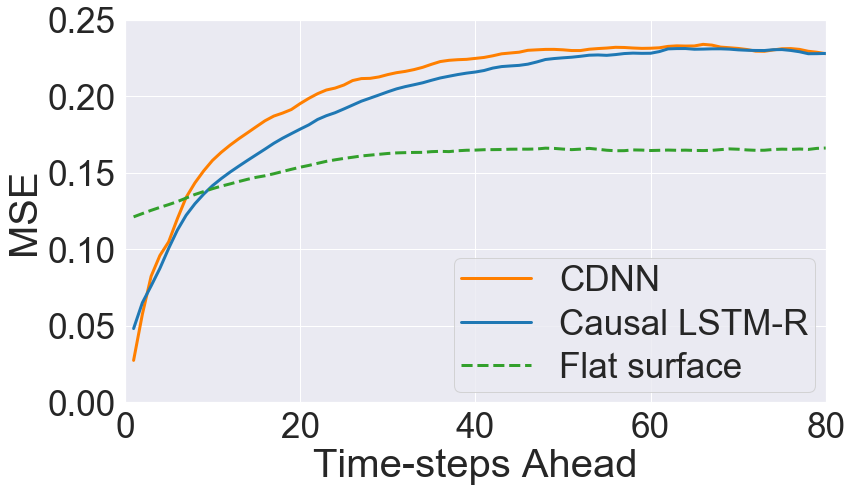

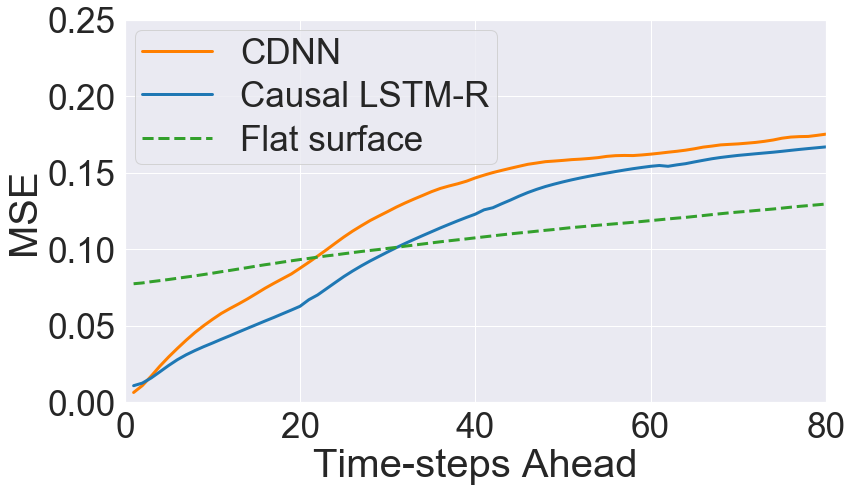

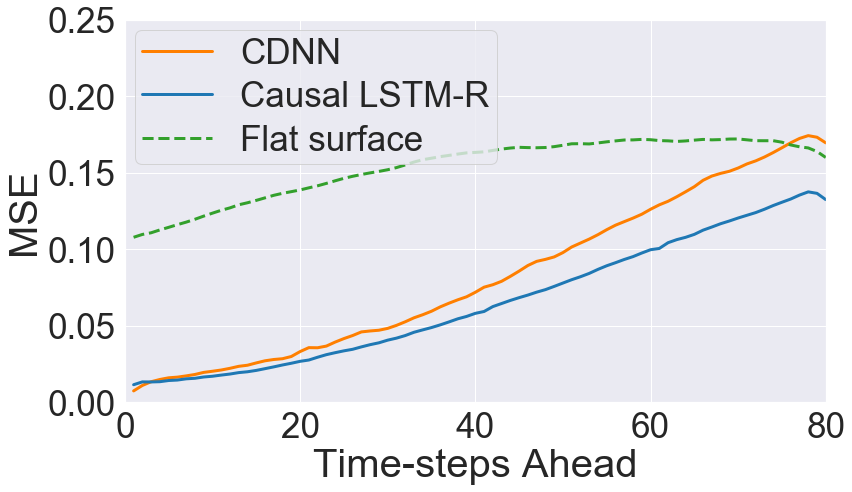

<Figure size 864x504 with 0 Axes>

In [105]:
metric = 'MSE'
baseline=''
exps = {
    'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7': 'CDNN',
 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated': 'Causal LSTM-R',
}
ci = None

ff=10
sns.set(rc={'figure.figsize':(12,7), 
            "lines.linewidth": 3,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

testset_names = {'Test': 'Original', 
                 'Lines': 'Lines', 
                 'Double_Drop': 'Double Drop', 
                 'Illumination_135': 'Illum. Opposite', 
                 'Illumination_Random' : 'Illum. Random',
                 'Shallow_Depth': 'Shallow Depth', 
                 'Smaller_Tub': 'Small Tank', 
                 'Bigger_Tub': 'Big Tank',
                'Fixed_Tub_10':'Fixed Tank'
                }

for test_set in testset_names.keys():
    evaluators_full = testset_exp_eval_full[test_set]

    dfs = []
    dfss = None
    df = None

    baseline=''
    for exp, name in exps.items():
#         print(exp)
        ev = evaluators_full[exp]
        x_title = 'Time-steps Ahead'
        y_title = metric
        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = name
        dfs.append(df)
        dfss = pd.concat(dfs)

    baselines = ['flat_image_'] # 'last_input_', 'previous_frame_']
    for baseline in baselines:
        x_title = 'Time-steps Ahead'
        y_title = metric
        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = legend[baseline]
        dfs.append(df)
        dfss = pd.concat(dfs)  

    ll = len(exps) + len(baselines)
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=None, palette=palette[:ll])
    ax.lines[2].set_linestyle("--")


    if metric == 'MSE':
        pass
        ax.set_ylim([0, 0.2])
        plt.yticks([0, 0.05, 0.1, 0.15, .20, .25])
    else:
        ax.set_ylim([0.5, 1])

    ax.set_xlim([0, 80])

    handles, labels = ax.get_legend_handles_labels()
    handles[3].set_linestyle("--")
    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

    plt.tight_layout()

    plt.savefig('results/wave_speed/%s_%s.pdf' % (test_set, metric))
    plt.figure()

# Baselines only

In [161]:
list(testset_exp_eval_full.keys())[:-1]

['Test',
 'Lines',
 'Double_Drop',
 'Illumination_135',
 'Illumination_Random',
 'Shallow_Depth',
 'Smaller_Tub',
 'Bigger_Tub']

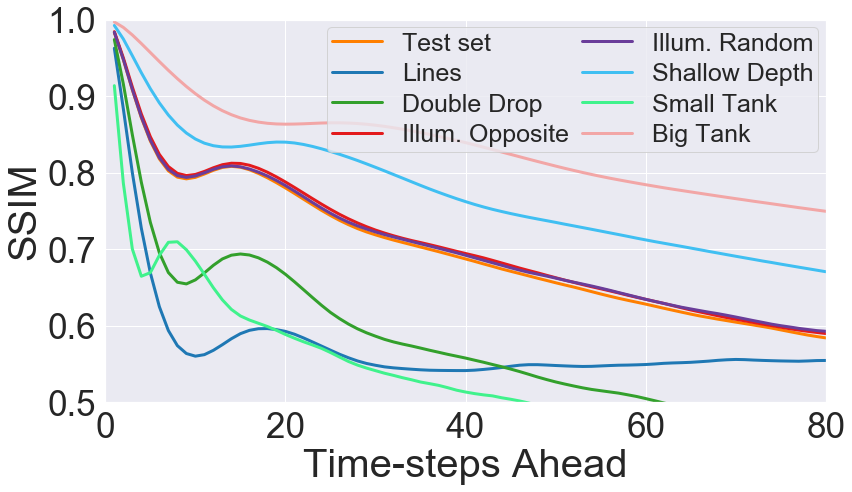

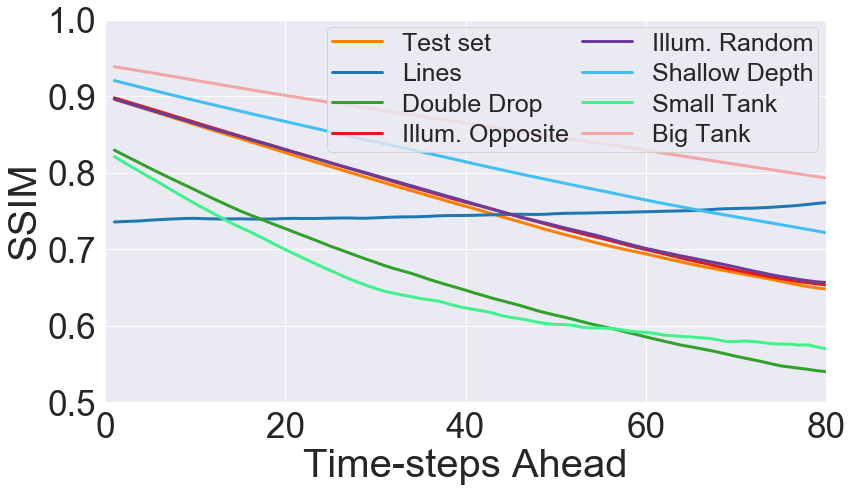

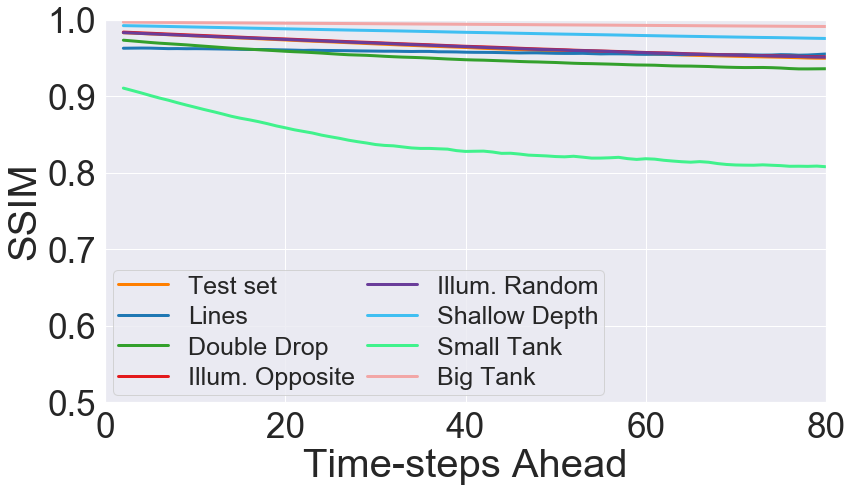

<Figure size 864x504 with 0 Axes>

In [289]:
ci = None

test_set = 'Test'

ff=10
sns.set(rc={'figure.figsize':(12,7), 
            "lines.linewidth": 3,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

# fig = plt.figure(figsize=(12,18)).add_axes()

metric='SSIM'
exp= 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7'
name='CDNN'

baselines = ['last_input_', 'flat_image_', 'previous_frame_']
            


for baseline in baselines:

    dfs = []
    dfss = None
    df = None

    for test_set in list(testset_exp_eval_full.keys())[:-1]:# ['Bigger_Tub', 'Smaller_Tub', 'Fixed_Tub_10']:
        evaluators_full = testset_exp_eval_full[test_set]

        # for baseline in baselines:
        ev = evaluators_full[exp]
        x_title = 'Time-steps Ahead'
        y_title = metric
        all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
            y_title:              ev.state['%s_%sval' % (metric, baseline)],
            "type":               ev.state['%s_%shue' % (metric,baseline)]}
        df = pd.DataFrame.from_dict(all_data)
        df['Line'] = testset_names[test_set]
        dfs.append(df)
        dfss = pd.concat(dfs)  

    ll = len(dfss.Line.unique())
    ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=None ,palette=palette[:ll])

    #     ax.lines[0].set_linestyle(":")
#     ax.lines[2].set_linestyle("--")

    m=0.20
    if metric == 'MSE':
        ax.set_ylim([0, m])
#         plt.yticks([0, 0.05, 0.1, 0.15, .20, .25, .3])
        pass
    else:
        ax.set_ylim([0.5, 1])

    ax.set_xlim([0, 80])

    handles, labels = ax.get_legend_handles_labels()
    #     handles[1].set_linestyle(":")
    # handles[3].set_linestyle("--")
    ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=2)

    plt.tight_layout()

#     print(baseline)
#     print(test_set)
    plt.savefig('results/wave_speed/baseline_%s_%s_%.2f.pdf' % (baseline[:-1], metric, m))
    plt.figure()

<Figure size 864x504 with 0 Axes>

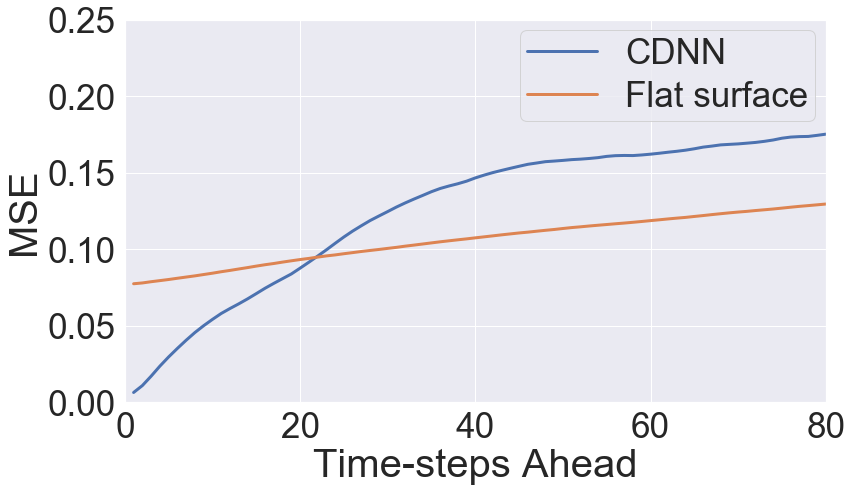

<Figure size 864x504 with 0 Axes>

In [153]:
metric = 'MSE'
baseline=''
exp= 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7'
name='CDNN'
ff=10
sns.set(rc={'figure.figsize':(12,7), 
            "lines.linewidth": 3,
            "axes.labelsize":30+ff,
            'ytick.labelsize': 25+ff,
            'xtick.labelsize': 25+ff,
            'legend.fontsize':25+ff, 
            'legend.borderpad': 0.2,
            'legend.columnspacing': 0.5, 
            'legend.labelspacing':0.3,
            'legend.borderaxespad': 0.3})

testset_names = {'Test': 'Original', 
                 'Lines': 'Lines', 
                 'Double_Drop': 'Double Drop', 
                 'Illumination_135': 'Illum. Opposite', 
                 'Illumination_Random' : 'Illum. Random',
                 'Shallow_Depth': 'Shallow Depth', 
                 'Smaller_Tub': 'Small Tank', 
                 'Bigger_Tub': 'Big Tank',
                'Fixed_Tub_10':'Fixed Tank'
                }

test_set = 'Bigger_Tub'

evaluators_full = testset_exp_eval_full[test_set]

dfs = []
dfss = None
df = None

baseline=''
#         print(exp)
ev = evaluators_full[exp]
x_title = 'Time-steps Ahead'
y_title = metric
all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
    y_title:              ev.state['%s_%sval' % (metric, baseline)],
    "type":               ev.state['%s_%shue' % (metric,baseline)]}
df = pd.DataFrame.from_dict(all_data)
df['Line'] = name
dfs.append(df)
dfss = pd.concat(dfs)

baselines = ['flat_image_'] # 'last_input_', 'previous_frame_']
for baseline in baselines:
    x_title = 'Time-steps Ahead'
    y_title = metric
    all_data={x_title:       [a+1 for a in ev.state['%s_%sframe' % (metric, baseline)]],
        y_title:              ev.state['%s_%sval' % (metric, baseline)],
        "type":               ev.state['%s_%shue' % (metric,baseline)]}
    df = pd.DataFrame.from_dict(all_data)
    df['Line'] = legend[baseline]
    dfs.append(df)
    dfss = pd.concat(dfs)  

ll = len(exps) + len(baselines)
ax = sns.lineplot(x="Time-steps Ahead", y=y_title, hue="Line", data=dfss, ax=fig, ci=None)#, palette=palette[:ll])
ax.lines[2].set_linestyle("--")


if metric == 'MSE':
    pass
    ax.set_ylim([0, 0.2])
    plt.yticks([0, 0.05, 0.1, 0.15, .20, .25])
else:
    ax.set_ylim([0.5, 1])

ax.set_xlim([0, 80])

handles, labels = ax.get_legend_handles_labels()
# handles[3].set_linestyle("--")
ax.legend(handles=handles[1:], labels=labels[1:], loc='best', ncol=1)

plt.tight_layout()

plt.savefig('results/wave_speed/debug.pdf')
plt.figure()